## Step 1: AWS Connection

In [1]:
import psycopg2
import os

try: 
    conn = psycopg2.connect(database='COMP5318', host='comp5318.cge7dneddtek.ap-southeast-2.rds.amazonaws.com',
                            user='COMP5318', password='COMP5318')
    print('Test Connection Successful!')
except Exception as e:
    print("Unable to connect to the database")
    print(e)

Test Connection Successful!


## Step 2: Query Function

In [2]:
#Query Function
def pgquery( conn, sqlcmd, args ):
   """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
   retval = False
   query_result = []
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            for record in cur:
                query_result.append(record)
            retval = True
         except Exception as e:
            print("DB Read Error: ")
            print(e)
   return query_result

#Execution Function
def pgexec( conn, sqlcmd, args, msg ):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if msg is not None:
                print("Success: " + msg)
            retval = True
         except Exception as e:
            print("DB Error: ")
            print(e)
   return retval

## Step 3: Create TRAINING and TEST data for Data Ingestion.

In [3]:
staging_adult_training_schema = """CREATE TABLE IF NOT EXISTS STG_ADULT_TRAINING
                      (age            varchar(100)
,workclass      varchar(100)
,fnlwgt         varchar(100)
,education      varchar(100)
,education_num  varchar(100)
,marital_status varchar(100)
,occupation     varchar(100)
,relationship   varchar(100)
,race           varchar(100)
,sex            varchar(100)
,capital_gain   varchar(100)
,capital_loss   varchar(100)
,hours_per_week varchar(100)
,native_country varchar(100)
,income_label   varchar(100)
                      )"""
pgexec (conn, staging_adult_training_schema, None, "Create Table Staging Adult Training")

staging_adult_test_schema = """CREATE TABLE IF NOT EXISTS STG_ADULT_TEST
                      (
age            varchar(100)
,workclass      varchar(100)
,fnlwgt         varchar(100)
,education      varchar(100)
,education_num  varchar(100)
,marital_status varchar(100)
,occupation     varchar(100)
,relationship   varchar(100)
,race           varchar(100)
,sex            varchar(100)
,capital_gain   varchar(100)
,capital_loss   varchar(100)
,hours_per_week varchar(100)
,native_country varchar(100)
,income_label   varchar(100)
                      )"""
pgexec (conn, staging_adult_test_schema, None, "Create Table Staging adult Test")

Success: Create Table Staging Adult Training
Success: Create Table Staging adult Test


True

## Step 4: Upload Data

`psql -h comp5318.cge7dneddtek.ap-southeast-2.rds.amazonaws.com -d COMP5318 -U COMP5318 -c "\copy stg_adult_training from 'adulttrain.txt' delimiter as ','"`

`psql -h comp5318.cge7dneddtek.ap-southeast-2.rds.amazonaws.com -d COMP5318 -U COMP5318 -c "\copy stg_adult_test from 'adulttest.txt' delimiter as ','"`

## Step 5: Libraries

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, average_precision_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.feature_selection import SelectKBest, f_classif
from matplotlib import font_manager 
from sklearn.svm import LinearSVC

# Set Default Font to Times New Roman
font_manager.findfont('Times New Roman')
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 

C:\Users\pastoem\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Step 6: Download Raw Data

In [4]:
query_stmt ="""
SELECT 
 age            
,workclass      
,fnlwgt         
,education      
,education_num  
,marital_status 
,occupation     
,relationship   
,race           
,sex            
,capital_gain   
,capital_loss   
,hours_per_week 
,native_country 
,income_label   
FROM stg_adult_training
;
"""

#Execute Query Statement
raw_train = pgquery (conn, query_stmt, None)

raw_traindata = pd.DataFrame(raw_train)

query_stmt ="""
SELECT 
 age            
,workclass      
,fnlwgt         
,education      
,education_num  
,marital_status 
,occupation     
,relationship   
,race           
,sex            
,capital_gain   
,capital_loss   
,hours_per_week 
,native_country 
,income_label   
FROM stg_adult_training
;
"""

#Execute Query Statement
raw_test = pgquery (conn, query_stmt, None)

raw_testdata = pd.DataFrame(raw_test)

## Step 7a: Download Full Data

In [5]:
query_stmt ="""
SELECT 
 cast(age AS INTEGER)
,CASE WHEN TRIM(workclass)='Federal-gov' THEN 1 ELSE 0 END AS  Federal_gov
,CASE WHEN TRIM(workclass)='Local-gov' THEN 1 ELSE 0 END AS  Local_gov
,CASE WHEN TRIM(workclass)='Never-worked' THEN 1 ELSE 0 END AS  Never_worked
,CASE WHEN TRIM(workclass)='Private' THEN 1 ELSE 0 END AS  Private
,CASE WHEN TRIM(workclass)='Self-emp-inc' THEN 1 ELSE 0 END AS  Self_emp_inc
,CASE WHEN TRIM(workclass)='Self-emp-not-inc' THEN 1 ELSE 0 END AS  Self_emp_not_inc
,CASE WHEN TRIM(workclass)='State-gov' THEN 1 ELSE 0 END AS  State_gov
,CASE WHEN TRIM(workclass)='Without-pay' THEN 1 ELSE 0 END AS  Without_pay
,cast(fnlwgt AS INTEGER)
,CASE WHEN TRIM(education)	='10th' THEN 1 ELSE 0 END AS  _10th
,CASE WHEN TRIM(education)	='11th' THEN 1 ELSE 0 END AS  _11th
,CASE WHEN TRIM(education)	='12th' THEN 1 ELSE 0 END AS  _12th
,CASE WHEN TRIM(education)	='1st-4th' THEN 1 ELSE 0 END AS  _1st_4th
,CASE WHEN TRIM(education)	='5th-6th' THEN 1 ELSE 0 END AS  _5th_6th
,CASE WHEN TRIM(education)	='7th-8th' THEN 1 ELSE 0 END AS  _7th_8th
,CASE WHEN TRIM(education)	='9th' THEN 1 ELSE 0 END AS  _9th
,CASE WHEN TRIM(education)	='Assoc-acdm' THEN 1 ELSE 0 END AS  Assoc_acdm
,CASE WHEN TRIM(education)	='Assoc-voc' THEN 1 ELSE 0 END AS  Assoc_voc
,CASE WHEN TRIM(education)	='Bachelors' THEN 1 ELSE 0 END AS  Bachelors
,CASE WHEN TRIM(education)	='Doctorate' THEN 1 ELSE 0 END AS  Doctorate
,CASE WHEN TRIM(education)	='HS-grad' THEN 1 ELSE 0 END AS  HS_grad
,CASE WHEN TRIM(education)	='Masters' THEN 1 ELSE 0 END AS  Masters
,CASE WHEN TRIM(education)	='Preschool' THEN 1 ELSE 0 END AS  Preschool
,CASE WHEN TRIM(education)	='Prof-school' THEN 1 ELSE 0 END AS  Prof_school
,CASE WHEN TRIM(education)	='Some-college' THEN 1 ELSE 0 END AS  Some_college
,CAST(education_num AS INTEGER)
,CASE WHEN TRIM(marital_status)	='Divorced' THEN 1 ELSE 0 END AS  Divorced
,CASE WHEN TRIM(marital_status)	='Married-AF-spouse' THEN 1 ELSE 0 END AS  Married_AF_spouse
,CASE WHEN TRIM(marital_status)	='Married-civ-spouse' THEN 1 ELSE 0 END AS  Married_civ_spouse
,CASE WHEN TRIM(marital_status)	='Married-spouse-absent' THEN 1 ELSE 0 END AS  Married_spouse_absent
,CASE WHEN TRIM(marital_status)	='Never-married' THEN 1 ELSE 0 END AS  Never_married
,CASE WHEN TRIM(marital_status)	='Separated' THEN 1 ELSE 0 END AS  Separated
,CASE WHEN TRIM(marital_status)	='Widowed' THEN 1 ELSE 0 END AS  Widowed
,CASE WHEN TRIM(occupation)	='Adm-clerical' THEN 1 ELSE 0 END AS  Adm_clerical
,CASE WHEN TRIM(occupation)	='Armed-Forces' THEN 1 ELSE 0 END AS  Armed_Forces
,CASE WHEN TRIM(occupation)	='Craft-repair' THEN 1 ELSE 0 END AS  Craft_repair
,CASE WHEN TRIM(occupation)	='Exec-managerial' THEN 1 ELSE 0 END AS  Exec_managerial
,CASE WHEN TRIM(occupation)	='Farming-fishing' THEN 1 ELSE 0 END AS  Farming_fishing
,CASE WHEN TRIM(occupation)	='Handlers-cleaners' THEN 1 ELSE 0 END AS  Handlers_cleaners
,CASE WHEN TRIM(occupation)	='Machine-op-inspct' THEN 1 ELSE 0 END AS  Machine_op_inspct
,CASE WHEN TRIM(occupation)	='Other-service' THEN 1 ELSE 0 END AS  Other_service
,CASE WHEN TRIM(occupation)	='Priv-house-serv' THEN 1 ELSE 0 END AS  Priv_house_serv
,CASE WHEN TRIM(occupation)	='Prof-specialty' THEN 1 ELSE 0 END AS  Prof_specialty
,CASE WHEN TRIM(occupation)	='Protective-serv' THEN 1 ELSE 0 END AS  Protective_serv
,CASE WHEN TRIM(occupation)	='Sales' THEN 1 ELSE 0 END AS  Sales
,CASE WHEN TRIM(occupation)	='Tech-support' THEN 1 ELSE 0 END AS  Tech_support
,CASE WHEN TRIM(occupation)	='Transport-moving' THEN 1 ELSE 0 END AS  Transport_moving
,CASE WHEN TRIM(relationship)	='Husband' THEN 1 ELSE 0 END AS  Husband
,CASE WHEN TRIM(relationship)	='Not-in-family' THEN 1 ELSE 0 END AS  Not_in_family
,CASE WHEN TRIM(relationship)	='Other-relative' THEN 1 ELSE 0 END AS  Other_relative
,CASE WHEN TRIM(relationship)	='Own-child' THEN 1 ELSE 0 END AS  Own_child
,CASE WHEN TRIM(relationship)	='Unmarried' THEN 1 ELSE 0 END AS  Unmarried
,CASE WHEN TRIM(relationship)	='Wife' THEN 1 ELSE 0 END AS  Wife
,CASE WHEN TRIM(race)	='Amer-Indian-Eskimo' THEN 1 ELSE 0 END AS  Amer_Indian_Eskimo
,CASE WHEN TRIM(race)	='Asian-Pac-Islander' THEN 1 ELSE 0 END AS  Asian_Pac_Islander
,CASE WHEN TRIM(race)	='Black' THEN 1 ELSE 0 END AS  Black
,CASE WHEN TRIM(race)	='Other' THEN 1 ELSE 0 END AS  Other
,CASE WHEN TRIM(race)	='White' THEN 1 ELSE 0 END AS  White
,CASE WHEN TRIM(sex)	='Female' THEN 1 ELSE 0 END AS  Gender
,CAST(capital_gain AS INTEGER) AS capital_gain
,CAST(capital_loss AS INTEGER) AS capital_loss
,CAST(hours_per_week AS INTEGER) AS hours_per_week
,CASE WHEN TRIM(native_country)	='Cambodia' THEN 1 ELSE 0 END AS  Cambodia
,CASE WHEN TRIM(native_country)	='Canada' THEN 1 ELSE 0 END AS  Canada
,CASE WHEN TRIM(native_country)	='China' THEN 1 ELSE 0 END AS  China
,CASE WHEN TRIM(native_country)	='Columbia' THEN 1 ELSE 0 END AS  Columbia
,CASE WHEN TRIM(native_country)	='Cuba' THEN 1 ELSE 0 END AS  Cuba
,CASE WHEN TRIM(native_country)	='Dominican-Republic' THEN 1 ELSE 0 END AS  Dominican_Republic
,CASE WHEN TRIM(native_country)	='Ecuador' THEN 1 ELSE 0 END AS  Ecuador
,CASE WHEN TRIM(native_country)	='El-Salvador' THEN 1 ELSE 0 END AS  El_Salvador
,CASE WHEN TRIM(native_country)	='England' THEN 1 ELSE 0 END AS  England
,CASE WHEN TRIM(native_country)	='France' THEN 1 ELSE 0 END AS  France
,CASE WHEN TRIM(native_country)	='Germany' THEN 1 ELSE 0 END AS  Germany
,CASE WHEN TRIM(native_country)	='Greece' THEN 1 ELSE 0 END AS  Greece
,CASE WHEN TRIM(native_country)	='Guatemala' THEN 1 ELSE 0 END AS  Guatemala
,CASE WHEN TRIM(native_country)	='Haiti' THEN 1 ELSE 0 END AS  Haiti
,CASE WHEN TRIM(native_country)	='Holand-Netherlands' THEN 1 ELSE 0 END AS  Holand_Netherlands
,CASE WHEN TRIM(native_country)	='Honduras' THEN 1 ELSE 0 END AS  Honduras
,CASE WHEN TRIM(native_country)	='Hong' THEN 1 ELSE 0 END AS  Hong
,CASE WHEN TRIM(native_country)	='Hungary' THEN 1 ELSE 0 END AS  Hungary
,CASE WHEN TRIM(native_country)	='India' THEN 1 ELSE 0 END AS  India
,CASE WHEN TRIM(native_country)	='Iran' THEN 1 ELSE 0 END AS  Iran
,CASE WHEN TRIM(native_country)	='Ireland' THEN 1 ELSE 0 END AS  Ireland
,CASE WHEN TRIM(native_country)	='Italy' THEN 1 ELSE 0 END AS  Italy
,CASE WHEN TRIM(native_country)	='Jamaica' THEN 1 ELSE 0 END AS  Jamaica
,CASE WHEN TRIM(native_country)	='Japan' THEN 1 ELSE 0 END AS  Japan
,CASE WHEN TRIM(native_country)	='Laos' THEN 1 ELSE 0 END AS  Laos
,CASE WHEN TRIM(native_country)	='Mexico' THEN 1 ELSE 0 END AS  Mexico
,CASE WHEN TRIM(native_country)	='Nicaragua' THEN 1 ELSE 0 END AS  Nicaragua
,CASE WHEN TRIM(native_country)	='Outlying-US(Guam-USVI-etc)' THEN 1 ELSE 0 END AS  Outlying_US
,CASE WHEN TRIM(native_country)	='Peru' THEN 1 ELSE 0 END AS  Peru
,CASE WHEN TRIM(native_country)	='Philippines' THEN 1 ELSE 0 END AS  Philippines
,CASE WHEN TRIM(native_country)	='Poland' THEN 1 ELSE 0 END AS  Poland
,CASE WHEN TRIM(native_country)	='Portugal' THEN 1 ELSE 0 END AS  Portugal
,CASE WHEN TRIM(native_country)	='Puerto-Rico' THEN 1 ELSE 0 END AS  Puerto_Rico
,CASE WHEN TRIM(native_country)	='Scotland' THEN 1 ELSE 0 END AS  Scotland
,CASE WHEN TRIM(native_country)	='South' THEN 1 ELSE 0 END AS  South
,CASE WHEN TRIM(native_country)	='Taiwan' THEN 1 ELSE 0 END AS  Taiwan
,CASE WHEN TRIM(native_country)	='Thailand' THEN 1 ELSE 0 END AS  Thailand
,CASE WHEN TRIM(native_country)	='Trinadad&Tobago' THEN 1 ELSE 0 END AS  TrinadadTobago
,CASE WHEN TRIM(native_country)	='United-States' THEN 1 ELSE 0 END AS  United_States
,CASE WHEN TRIM(native_country)	='Vietnam' THEN 1 ELSE 0 END AS  Vietnam
,CASE WHEN TRIM(native_country)	='Yugoslavia' THEN 1 ELSE 0 END AS  Yugoslavia
,CASE WHEN TRIM(income_label)	='>50K' THEN 1 ELSE 0 END AS  target_output
FROM stg_adult_training
;
"""

#Execute Query Statement
orig_train = pgquery (conn, query_stmt, None)

orig_traindata = pd.DataFrame(orig_train)

In [6]:
query_stmt ="""
SELECT 
 cast(age AS INTEGER)
,CASE WHEN TRIM(workclass)='Federal-gov' THEN 1 ELSE 0 END AS  Federal_gov
,CASE WHEN TRIM(workclass)='Local-gov' THEN 1 ELSE 0 END AS  Local_gov
,CASE WHEN TRIM(workclass)='Never-worked' THEN 1 ELSE 0 END AS  Never_worked
,CASE WHEN TRIM(workclass)='Private' THEN 1 ELSE 0 END AS  Private
,CASE WHEN TRIM(workclass)='Self-emp-inc' THEN 1 ELSE 0 END AS  Self_emp_inc
,CASE WHEN TRIM(workclass)='Self-emp-not-inc' THEN 1 ELSE 0 END AS  Self_emp_not_inc
,CASE WHEN TRIM(workclass)='State-gov' THEN 1 ELSE 0 END AS  State_gov
,CASE WHEN TRIM(workclass)='Without-pay' THEN 1 ELSE 0 END AS  Without_pay
,cast(fnlwgt AS INTEGER)
,CASE WHEN TRIM(education)	='10th' THEN 1 ELSE 0 END AS  _10th
,CASE WHEN TRIM(education)	='11th' THEN 1 ELSE 0 END AS  _11th
,CASE WHEN TRIM(education)	='12th' THEN 1 ELSE 0 END AS  _12th
,CASE WHEN TRIM(education)	='1st-4th' THEN 1 ELSE 0 END AS  _1st_4th
,CASE WHEN TRIM(education)	='5th-6th' THEN 1 ELSE 0 END AS  _5th_6th
,CASE WHEN TRIM(education)	='7th-8th' THEN 1 ELSE 0 END AS  _7th_8th
,CASE WHEN TRIM(education)	='9th' THEN 1 ELSE 0 END AS  _9th
,CASE WHEN TRIM(education)	='Assoc-acdm' THEN 1 ELSE 0 END AS  Assoc_acdm
,CASE WHEN TRIM(education)	='Assoc-voc' THEN 1 ELSE 0 END AS  Assoc_voc
,CASE WHEN TRIM(education)	='Bachelors' THEN 1 ELSE 0 END AS  Bachelors
,CASE WHEN TRIM(education)	='Doctorate' THEN 1 ELSE 0 END AS  Doctorate
,CASE WHEN TRIM(education)	='HS-grad' THEN 1 ELSE 0 END AS  HS_grad
,CASE WHEN TRIM(education)	='Masters' THEN 1 ELSE 0 END AS  Masters
,CASE WHEN TRIM(education)	='Preschool' THEN 1 ELSE 0 END AS  Preschool
,CASE WHEN TRIM(education)	='Prof-school' THEN 1 ELSE 0 END AS  Prof_school
,CASE WHEN TRIM(education)	='Some-college' THEN 1 ELSE 0 END AS  Some_college
,CAST(education_num AS INTEGER)
,CASE WHEN TRIM(marital_status)	='Divorced' THEN 1 ELSE 0 END AS  Divorced
,CASE WHEN TRIM(marital_status)	='Married-AF-spouse' THEN 1 ELSE 0 END AS  Married_AF_spouse
,CASE WHEN TRIM(marital_status)	='Married-civ-spouse' THEN 1 ELSE 0 END AS  Married_civ_spouse
,CASE WHEN TRIM(marital_status)	='Married-spouse-absent' THEN 1 ELSE 0 END AS  Married_spouse_absent
,CASE WHEN TRIM(marital_status)	='Never-married' THEN 1 ELSE 0 END AS  Never_married
,CASE WHEN TRIM(marital_status)	='Separated' THEN 1 ELSE 0 END AS  Separated
,CASE WHEN TRIM(marital_status)	='Widowed' THEN 1 ELSE 0 END AS  Widowed
,CASE WHEN TRIM(occupation)	='Adm-clerical' THEN 1 ELSE 0 END AS  Adm_clerical
,CASE WHEN TRIM(occupation)	='Armed-Forces' THEN 1 ELSE 0 END AS  Armed_Forces
,CASE WHEN TRIM(occupation)	='Craft-repair' THEN 1 ELSE 0 END AS  Craft_repair
,CASE WHEN TRIM(occupation)	='Exec-managerial' THEN 1 ELSE 0 END AS  Exec_managerial
,CASE WHEN TRIM(occupation)	='Farming-fishing' THEN 1 ELSE 0 END AS  Farming_fishing
,CASE WHEN TRIM(occupation)	='Handlers-cleaners' THEN 1 ELSE 0 END AS  Handlers_cleaners
,CASE WHEN TRIM(occupation)	='Machine-op-inspct' THEN 1 ELSE 0 END AS  Machine_op_inspct
,CASE WHEN TRIM(occupation)	='Other-service' THEN 1 ELSE 0 END AS  Other_service
,CASE WHEN TRIM(occupation)	='Priv-house-serv' THEN 1 ELSE 0 END AS  Priv_house_serv
,CASE WHEN TRIM(occupation)	='Prof-specialty' THEN 1 ELSE 0 END AS  Prof_specialty
,CASE WHEN TRIM(occupation)	='Protective-serv' THEN 1 ELSE 0 END AS  Protective_serv
,CASE WHEN TRIM(occupation)	='Sales' THEN 1 ELSE 0 END AS  Sales
,CASE WHEN TRIM(occupation)	='Tech-support' THEN 1 ELSE 0 END AS  Tech_support
,CASE WHEN TRIM(occupation)	='Transport-moving' THEN 1 ELSE 0 END AS  Transport_moving
,CASE WHEN TRIM(relationship)	='Husband' THEN 1 ELSE 0 END AS  Husband
,CASE WHEN TRIM(relationship)	='Not-in-family' THEN 1 ELSE 0 END AS  Not_in_family
,CASE WHEN TRIM(relationship)	='Other-relative' THEN 1 ELSE 0 END AS  Other_relative
,CASE WHEN TRIM(relationship)	='Own-child' THEN 1 ELSE 0 END AS  Own_child
,CASE WHEN TRIM(relationship)	='Unmarried' THEN 1 ELSE 0 END AS  Unmarried
,CASE WHEN TRIM(relationship)	='Wife' THEN 1 ELSE 0 END AS  Wife
,CASE WHEN TRIM(race)	='Amer-Indian-Eskimo' THEN 1 ELSE 0 END AS  Amer_Indian_Eskimo
,CASE WHEN TRIM(race)	='Asian-Pac-Islander' THEN 1 ELSE 0 END AS  Asian_Pac_Islander
,CASE WHEN TRIM(race)	='Black' THEN 1 ELSE 0 END AS  Black
,CASE WHEN TRIM(race)	='Other' THEN 1 ELSE 0 END AS  Other
,CASE WHEN TRIM(race)	='White' THEN 1 ELSE 0 END AS  White
,CASE WHEN TRIM(sex)	='Female' THEN 1 ELSE 0 END AS  Gender
,CAST(capital_gain AS INTEGER) AS capital_gain
,CAST(capital_loss AS INTEGER) AS capital_loss
,CAST(hours_per_week AS INTEGER) AS hours_per_week
,CASE WHEN TRIM(native_country)	='Cambodia' THEN 1 ELSE 0 END AS  Cambodia
,CASE WHEN TRIM(native_country)	='Canada' THEN 1 ELSE 0 END AS  Canada
,CASE WHEN TRIM(native_country)	='China' THEN 1 ELSE 0 END AS  China
,CASE WHEN TRIM(native_country)	='Columbia' THEN 1 ELSE 0 END AS  Columbia
,CASE WHEN TRIM(native_country)	='Cuba' THEN 1 ELSE 0 END AS  Cuba
,CASE WHEN TRIM(native_country)	='Dominican-Republic' THEN 1 ELSE 0 END AS  Dominican_Republic
,CASE WHEN TRIM(native_country)	='Ecuador' THEN 1 ELSE 0 END AS  Ecuador
,CASE WHEN TRIM(native_country)	='El-Salvador' THEN 1 ELSE 0 END AS  El_Salvador
,CASE WHEN TRIM(native_country)	='England' THEN 1 ELSE 0 END AS  England
,CASE WHEN TRIM(native_country)	='France' THEN 1 ELSE 0 END AS  France
,CASE WHEN TRIM(native_country)	='Germany' THEN 1 ELSE 0 END AS  Germany
,CASE WHEN TRIM(native_country)	='Greece' THEN 1 ELSE 0 END AS  Greece
,CASE WHEN TRIM(native_country)	='Guatemala' THEN 1 ELSE 0 END AS  Guatemala
,CASE WHEN TRIM(native_country)	='Haiti' THEN 1 ELSE 0 END AS  Haiti
,CASE WHEN TRIM(native_country)	='Holand-Netherlands' THEN 1 ELSE 0 END AS  Holand_Netherlands
,CASE WHEN TRIM(native_country)	='Honduras' THEN 1 ELSE 0 END AS  Honduras
,CASE WHEN TRIM(native_country)	='Hong' THEN 1 ELSE 0 END AS  Hong
,CASE WHEN TRIM(native_country)	='Hungary' THEN 1 ELSE 0 END AS  Hungary
,CASE WHEN TRIM(native_country)	='India' THEN 1 ELSE 0 END AS  India
,CASE WHEN TRIM(native_country)	='Iran' THEN 1 ELSE 0 END AS  Iran
,CASE WHEN TRIM(native_country)	='Ireland' THEN 1 ELSE 0 END AS  Ireland
,CASE WHEN TRIM(native_country)	='Italy' THEN 1 ELSE 0 END AS  Italy
,CASE WHEN TRIM(native_country)	='Jamaica' THEN 1 ELSE 0 END AS  Jamaica
,CASE WHEN TRIM(native_country)	='Japan' THEN 1 ELSE 0 END AS  Japan
,CASE WHEN TRIM(native_country)	='Laos' THEN 1 ELSE 0 END AS  Laos
,CASE WHEN TRIM(native_country)	='Mexico' THEN 1 ELSE 0 END AS  Mexico
,CASE WHEN TRIM(native_country)	='Nicaragua' THEN 1 ELSE 0 END AS  Nicaragua
,CASE WHEN TRIM(native_country)	='Outlying-US(Guam-USVI-etc)' THEN 1 ELSE 0 END AS  Outlying_US
,CASE WHEN TRIM(native_country)	='Peru' THEN 1 ELSE 0 END AS  Peru
,CASE WHEN TRIM(native_country)	='Philippines' THEN 1 ELSE 0 END AS  Philippines
,CASE WHEN TRIM(native_country)	='Poland' THEN 1 ELSE 0 END AS  Poland
,CASE WHEN TRIM(native_country)	='Portugal' THEN 1 ELSE 0 END AS  Portugal
,CASE WHEN TRIM(native_country)	='Puerto-Rico' THEN 1 ELSE 0 END AS  Puerto_Rico
,CASE WHEN TRIM(native_country)	='Scotland' THEN 1 ELSE 0 END AS  Scotland
,CASE WHEN TRIM(native_country)	='South' THEN 1 ELSE 0 END AS  South
,CASE WHEN TRIM(native_country)	='Taiwan' THEN 1 ELSE 0 END AS  Taiwan
,CASE WHEN TRIM(native_country)	='Thailand' THEN 1 ELSE 0 END AS  Thailand
,CASE WHEN TRIM(native_country)	='Trinadad&Tobago' THEN 1 ELSE 0 END AS  TrinadadTobago
,CASE WHEN TRIM(native_country)	='United-States' THEN 1 ELSE 0 END AS  United_States
,CASE WHEN TRIM(native_country)	='Vietnam' THEN 1 ELSE 0 END AS  Vietnam
,CASE WHEN TRIM(native_country)	='Yugoslavia' THEN 1 ELSE 0 END AS  Yugoslavia
,CASE WHEN TRIM(income_label)	='>50K.' THEN 1 ELSE 0 END AS  target_output
FROM stg_adult_test
"""

#Execute Query Statement
orig_test = pgquery (conn, query_stmt, None)

orig_testdata = pd.DataFrame(orig_test)

## Step 7b: Download One Hot Encoded Data

In [7]:
query_stmt ="""
SELECT 
 cast(age AS INTEGER)
,CASE WHEN TRIM(workclass)='Federal-gov' THEN 1 ELSE 0 END AS  Federal_gov
,CASE WHEN TRIM(workclass)='Local-gov' THEN 1 ELSE 0 END AS  Local_gov
--,CASE WHEN TRIM(workclass)='Never-worked' THEN 1 ELSE 0 END AS  Never_worked
,CASE WHEN TRIM(workclass)='Private' THEN 1 ELSE 0 END AS  Private
,CASE WHEN TRIM(workclass)='Self-emp-inc' THEN 1 ELSE 0 END AS  Self_emp_inc
,CASE WHEN TRIM(workclass)='Self-emp-not-inc' THEN 1 ELSE 0 END AS  Self_emp_not_inc
,CASE WHEN TRIM(workclass)='State-gov' THEN 1 ELSE 0 END AS  State_gov
,CASE WHEN TRIM(workclass)='Without-pay' THEN 1 ELSE 0 END AS  Without_pay
,cast(fnlwgt AS INTEGER)
,CAST(education_num AS INTEGER)
,CASE WHEN TRIM(marital_status) IN ('Married-AF-spouse', 'Married-civ-spouse') THEN 1
      WHEN TRIM(relationship) IN ('Husband', 'Wife') THEN 1
      ELSE 0 END AS  Married
,CASE WHEN TRIM(occupation)	='Adm-clerical' THEN 1 ELSE 0 END AS  Adm_clerical
,CASE WHEN TRIM(occupation)	='Armed-Forces' THEN 1 ELSE 0 END AS  Armed_Forces
,CASE WHEN TRIM(occupation)	='Craft-repair' THEN 1 ELSE 0 END AS  Craft_repair
,CASE WHEN TRIM(occupation)	='Exec-managerial' THEN 1 ELSE 0 END AS  Exec_managerial
,CASE WHEN TRIM(occupation)	='Farming-fishing' THEN 1 ELSE 0 END AS  Farming_fishing
,CASE WHEN TRIM(occupation)	='Handlers-cleaners' THEN 1 ELSE 0 END AS  Handlers_cleaners
,CASE WHEN TRIM(occupation)	='Machine-op-inspct' THEN 1 ELSE 0 END AS  Machine_op_inspct
,CASE WHEN TRIM(occupation)	='Other-service' THEN 1 ELSE 0 END AS  Other_service
,CASE WHEN TRIM(occupation)	='Priv-house-serv' THEN 1 ELSE 0 END AS  Priv_house_serv
,CASE WHEN TRIM(occupation)	='Prof-specialty' THEN 1 ELSE 0 END AS  Prof_specialty
,CASE WHEN TRIM(occupation)	='Protective-serv' THEN 1 ELSE 0 END AS  Protective_serv
,CASE WHEN TRIM(occupation)	='Sales' THEN 1 ELSE 0 END AS  Sales
,CASE WHEN TRIM(occupation)	='Tech-support' THEN 1 ELSE 0 END AS  Tech_support
,CASE WHEN TRIM(occupation)	='Transport-moving' THEN 1 ELSE 0 END AS  Transport_moving
,CASE WHEN TRIM(race)	='Amer-Indian-Eskimo' THEN 1 ELSE 0 END AS  Amer_Indian_Eskimo
,CASE WHEN TRIM(race)	='Asian-Pac-Islander' THEN 1 ELSE 0 END AS  Asian_Pac_Islander
,CASE WHEN TRIM(race)	='Black' THEN 1 ELSE 0 END AS  Black
,CASE WHEN TRIM(race)	='Other' THEN 1 ELSE 0 END AS  Other
,CASE WHEN TRIM(race)	='White' THEN 1 ELSE 0 END AS  White
,CASE WHEN TRIM(sex)	='Female' THEN 1 ELSE 0 END AS  Gender
,CAST(capital_gain AS INTEGER) AS capital_gain
,CAST(capital_loss AS INTEGER) AS capital_loss
,CAST(hours_per_week AS INTEGER) AS hours_per_week
,CASE WHEN TRIM(native_country)	='Cambodia' THEN 1 ELSE 0 END AS  Country_Cambodia
,CASE WHEN TRIM(native_country)	='Canada' THEN 1 ELSE 0 END AS  Country_Canada
,CASE WHEN TRIM(native_country)	='China' THEN 1 ELSE 0 END AS  Country_China
,CASE WHEN TRIM(native_country)	='Columbia' THEN 1 ELSE 0 END AS  Country_Columbia
,CASE WHEN TRIM(native_country)	='Cuba' THEN 1 ELSE 0 END AS  Country_Cuba
,CASE WHEN TRIM(native_country)	='Dominican-Republic' THEN 1 ELSE 0 END AS  Country_Dominican_Republic
,CASE WHEN TRIM(native_country)	='Ecuador' THEN 1 ELSE 0 END AS  Country_Ecuador
,CASE WHEN TRIM(native_country)	='El-Salvador' THEN 1 ELSE 0 END AS  Country_El_Salvador
,CASE WHEN TRIM(native_country)	='England' THEN 1 ELSE 0 END AS  Country_England
,CASE WHEN TRIM(native_country)	='France' THEN 1 ELSE 0 END AS  Country_France
,CASE WHEN TRIM(native_country)	='Germany' THEN 1 ELSE 0 END AS  Country_Germany
,CASE WHEN TRIM(native_country)	='Greece' THEN 1 ELSE 0 END AS  Country_Greece
,CASE WHEN TRIM(native_country)	='Guatemala' THEN 1 ELSE 0 END AS  Country_Guatemala
,CASE WHEN TRIM(native_country)	='Haiti' THEN 1 ELSE 0 END AS  Country_Haiti
,CASE WHEN TRIM(native_country)	='Holand-Netherlands' THEN 1 ELSE 0 END AS  Country_Holand_Netherlands
,CASE WHEN TRIM(native_country)	='Honduras' THEN 1 ELSE 0 END AS  Country_Honduras
,CASE WHEN TRIM(native_country)	='Hong' THEN 1 ELSE 0 END AS  Country_Hong
,CASE WHEN TRIM(native_country)	='Hungary' THEN 1 ELSE 0 END AS  Country_Hungary
,CASE WHEN TRIM(native_country)	='India' THEN 1 ELSE 0 END AS  Country_India
,CASE WHEN TRIM(native_country)	='Iran' THEN 1 ELSE 0 END AS  Country_Iran
,CASE WHEN TRIM(native_country)	='Ireland' THEN 1 ELSE 0 END AS  Country_Ireland
,CASE WHEN TRIM(native_country)	='Italy' THEN 1 ELSE 0 END AS  Country_Italy
,CASE WHEN TRIM(native_country)	='Jamaica' THEN 1 ELSE 0 END AS  Country_Jamaica
,CASE WHEN TRIM(native_country)	='Japan' THEN 1 ELSE 0 END AS  Country_Japan
,CASE WHEN TRIM(native_country)	='Laos' THEN 1 ELSE 0 END AS  Country_Laos
,CASE WHEN TRIM(native_country)	='Mexico' THEN 1 ELSE 0 END AS  Country_Mexico
,CASE WHEN TRIM(native_country)	='Nicaragua' THEN 1 ELSE 0 END AS  Country_Nicaragua
,CASE WHEN TRIM(native_country)	='Outlying-US(Guam-USVI-etc)' THEN 1 ELSE 0 END AS  Country_Outlying_US
,CASE WHEN TRIM(native_country)	='Peru' THEN 1 ELSE 0 END AS  Country_Peru
,CASE WHEN TRIM(native_country)	='Philippines' THEN 1 ELSE 0 END AS  Country_Philippines
,CASE WHEN TRIM(native_country)	='Poland' THEN 1 ELSE 0 END AS  Country_Poland
,CASE WHEN TRIM(native_country)	='Portugal' THEN 1 ELSE 0 END AS  Country_Portugal
,CASE WHEN TRIM(native_country)	='Puerto-Rico' THEN 1 ELSE 0 END AS  Country_Puerto_Rico
,CASE WHEN TRIM(native_country)	='Scotland' THEN 1 ELSE 0 END AS  Country_Scotland
,CASE WHEN TRIM(native_country)	='South' THEN 1 ELSE 0 END AS  Country_South
,CASE WHEN TRIM(native_country)	='Taiwan' THEN 1 ELSE 0 END AS  Country_Taiwan
,CASE WHEN TRIM(native_country)	='Thailand' THEN 1 ELSE 0 END AS  Country_Thailand
,CASE WHEN TRIM(native_country)	='Trinadad&Tobago' THEN 1 ELSE 0 END AS  Country_TrinadadTobago
,CASE WHEN TRIM(native_country)	='United-States' THEN 1 ELSE 0 END AS  Country_United_States
,CASE WHEN TRIM(native_country)	='Vietnam' THEN 1 ELSE 0 END AS  Country_Vietnam
,CASE WHEN TRIM(native_country)	='Yugoslavia' THEN 1 ELSE 0 END AS  Country_Yugoslavia
,CASE WHEN TRIM(income_label)	='>50K' THEN 1 ELSE 0 END AS  target_output
FROM stg_adult_training
WHERE TRIM(workclass) <> ''
AND TRIM(occupation) <> ''
AND TRIM(native_country) <> ''
;
"""

#Execute Query Statement
train = pgquery (conn, query_stmt, None)

traindata = pd.DataFrame(train)

In [8]:
query_stmt ="""
SELECT 
 cast(age AS INTEGER)
,CASE WHEN TRIM(workclass)='Federal-gov' THEN 1 ELSE 0 END AS  Federal_gov
,CASE WHEN TRIM(workclass)='Local-gov' THEN 1 ELSE 0 END AS  Local_gov
--,CASE WHEN TRIM(workclass)='Never-worked' THEN 1 ELSE 0 END AS  Never_worked
,CASE WHEN TRIM(workclass)='Private' THEN 1 ELSE 0 END AS  Private
,CASE WHEN TRIM(workclass)='Self-emp-inc' THEN 1 ELSE 0 END AS  Self_emp_inc
,CASE WHEN TRIM(workclass)='Self-emp-not-inc' THEN 1 ELSE 0 END AS  Self_emp_not_inc
,CASE WHEN TRIM(workclass)='State-gov' THEN 1 ELSE 0 END AS  State_gov
,CASE WHEN TRIM(workclass)='Without-pay' THEN 1 ELSE 0 END AS  Without_pay
,cast(fnlwgt AS INTEGER)
,CAST(education_num AS INTEGER)
,CASE WHEN TRIM(marital_status) IN ('Married-AF-spouse', 'Married-civ-spouse') THEN 1
      WHEN TRIM(relationship) IN ('Husband', 'Wife') THEN 1
      ELSE 0 END AS  Married
,CASE WHEN TRIM(occupation)	='Adm-clerical' THEN 1 ELSE 0 END AS  Adm_clerical
,CASE WHEN TRIM(occupation)	='Armed-Forces' THEN 1 ELSE 0 END AS  Armed_Forces
,CASE WHEN TRIM(occupation)	='Craft-repair' THEN 1 ELSE 0 END AS  Craft_repair
,CASE WHEN TRIM(occupation)	='Exec-managerial' THEN 1 ELSE 0 END AS  Exec_managerial
,CASE WHEN TRIM(occupation)	='Farming-fishing' THEN 1 ELSE 0 END AS  Farming_fishing
,CASE WHEN TRIM(occupation)	='Handlers-cleaners' THEN 1 ELSE 0 END AS  Handlers_cleaners
,CASE WHEN TRIM(occupation)	='Machine-op-inspct' THEN 1 ELSE 0 END AS  Machine_op_inspct
,CASE WHEN TRIM(occupation)	='Other-service' THEN 1 ELSE 0 END AS  Other_service
,CASE WHEN TRIM(occupation)	='Priv-house-serv' THEN 1 ELSE 0 END AS  Priv_house_serv
,CASE WHEN TRIM(occupation)	='Prof-specialty' THEN 1 ELSE 0 END AS  Prof_specialty
,CASE WHEN TRIM(occupation)	='Protective-serv' THEN 1 ELSE 0 END AS  Protective_serv
,CASE WHEN TRIM(occupation)	='Sales' THEN 1 ELSE 0 END AS  Sales
,CASE WHEN TRIM(occupation)	='Tech-support' THEN 1 ELSE 0 END AS  Tech_support
,CASE WHEN TRIM(occupation)	='Transport-moving' THEN 1 ELSE 0 END AS  Transport_moving
,CASE WHEN TRIM(race)	='Amer-Indian-Eskimo' THEN 1 ELSE 0 END AS  Amer_Indian_Eskimo
,CASE WHEN TRIM(race)	='Asian-Pac-Islander' THEN 1 ELSE 0 END AS  Asian_Pac_Islander
,CASE WHEN TRIM(race)	='Black' THEN 1 ELSE 0 END AS  Black
,CASE WHEN TRIM(race)	='Other' THEN 1 ELSE 0 END AS  Other
,CASE WHEN TRIM(race)	='White' THEN 1 ELSE 0 END AS  White
,CASE WHEN TRIM(sex)	='Female' THEN 1 ELSE 0 END AS  Gender
,CAST(capital_gain AS INTEGER) AS capital_gain
,CAST(capital_loss AS INTEGER) AS capital_loss
,CAST(hours_per_week AS INTEGER) AS hours_per_week
,CASE WHEN TRIM(native_country)	='Cambodia' THEN 1 ELSE 0 END AS  Country_Cambodia
,CASE WHEN TRIM(native_country)	='Canada' THEN 1 ELSE 0 END AS  Country_Canada
,CASE WHEN TRIM(native_country)	='China' THEN 1 ELSE 0 END AS  Country_China
,CASE WHEN TRIM(native_country)	='Columbia' THEN 1 ELSE 0 END AS  Country_Columbia
,CASE WHEN TRIM(native_country)	='Cuba' THEN 1 ELSE 0 END AS  Country_Cuba
,CASE WHEN TRIM(native_country)	='Dominican-Republic' THEN 1 ELSE 0 END AS  Country_Dominican_Republic
,CASE WHEN TRIM(native_country)	='Ecuador' THEN 1 ELSE 0 END AS  Country_Ecuador
,CASE WHEN TRIM(native_country)	='El-Salvador' THEN 1 ELSE 0 END AS  Country_El_Salvador
,CASE WHEN TRIM(native_country)	='England' THEN 1 ELSE 0 END AS  Country_England
,CASE WHEN TRIM(native_country)	='France' THEN 1 ELSE 0 END AS  Country_France
,CASE WHEN TRIM(native_country)	='Germany' THEN 1 ELSE 0 END AS  Country_Germany
,CASE WHEN TRIM(native_country)	='Greece' THEN 1 ELSE 0 END AS  Country_Greece
,CASE WHEN TRIM(native_country)	='Guatemala' THEN 1 ELSE 0 END AS  Country_Guatemala
,CASE WHEN TRIM(native_country)	='Haiti' THEN 1 ELSE 0 END AS  Country_Haiti
,CASE WHEN TRIM(native_country)	='Holand-Netherlands' THEN 1 ELSE 0 END AS  Country_Holand_Netherlands
,CASE WHEN TRIM(native_country)	='Honduras' THEN 1 ELSE 0 END AS  Country_Honduras
,CASE WHEN TRIM(native_country)	='Hong' THEN 1 ELSE 0 END AS  Country_Hong
,CASE WHEN TRIM(native_country)	='Hungary' THEN 1 ELSE 0 END AS  Country_Hungary
,CASE WHEN TRIM(native_country)	='India' THEN 1 ELSE 0 END AS  Country_India
,CASE WHEN TRIM(native_country)	='Iran' THEN 1 ELSE 0 END AS  Country_Iran
,CASE WHEN TRIM(native_country)	='Ireland' THEN 1 ELSE 0 END AS  Country_Ireland
,CASE WHEN TRIM(native_country)	='Italy' THEN 1 ELSE 0 END AS  Country_Italy
,CASE WHEN TRIM(native_country)	='Jamaica' THEN 1 ELSE 0 END AS  Country_Jamaica
,CASE WHEN TRIM(native_country)	='Japan' THEN 1 ELSE 0 END AS  Country_Japan
,CASE WHEN TRIM(native_country)	='Laos' THEN 1 ELSE 0 END AS  Country_Laos
,CASE WHEN TRIM(native_country)	='Mexico' THEN 1 ELSE 0 END AS  Country_Mexico
,CASE WHEN TRIM(native_country)	='Nicaragua' THEN 1 ELSE 0 END AS  Country_Nicaragua
,CASE WHEN TRIM(native_country)	='Outlying-US(Guam-USVI-etc)' THEN 1 ELSE 0 END AS  Country_Outlying_US
,CASE WHEN TRIM(native_country)	='Peru' THEN 1 ELSE 0 END AS  Country_Peru
,CASE WHEN TRIM(native_country)	='Philippines' THEN 1 ELSE 0 END AS  Country_Philippines
,CASE WHEN TRIM(native_country)	='Poland' THEN 1 ELSE 0 END AS  Country_Poland
,CASE WHEN TRIM(native_country)	='Portugal' THEN 1 ELSE 0 END AS  Country_Portugal
,CASE WHEN TRIM(native_country)	='Puerto-Rico' THEN 1 ELSE 0 END AS  Country_Puerto_Rico
,CASE WHEN TRIM(native_country)	='Scotland' THEN 1 ELSE 0 END AS  Country_Scotland
,CASE WHEN TRIM(native_country)	='South' THEN 1 ELSE 0 END AS  Country_South
,CASE WHEN TRIM(native_country)	='Taiwan' THEN 1 ELSE 0 END AS  Country_Taiwan
,CASE WHEN TRIM(native_country)	='Thailand' THEN 1 ELSE 0 END AS  Country_Thailand
,CASE WHEN TRIM(native_country)	='Trinadad&Tobago' THEN 1 ELSE 0 END AS  Country_TrinadadTobago
,CASE WHEN TRIM(native_country)	='United-States' THEN 1 ELSE 0 END AS  Country_United_States
,CASE WHEN TRIM(native_country)	='Vietnam' THEN 1 ELSE 0 END AS  Country_Vietnam
,CASE WHEN TRIM(native_country)	='Yugoslavia' THEN 1 ELSE 0 END AS  Country_Yugoslavia
,CASE WHEN TRIM(income_label)	='>50K.' THEN 1 ELSE 0 END AS  target_output
FROM stg_adult_test
WHERE TRIM(workclass) <> ''
AND TRIM(occupation) <> ''
AND TRIM(native_country) <> ''
"""

#Execute Query Statement
test = pgquery (conn, query_stmt, None)

testdata = pd.DataFrame(test)

## Step 8: Separate X and Y data using the original ratio of train and test data

In [9]:
X_train = traindata.iloc[:,:-1]
Y_train = np.array(traindata.iloc[:,-1:]).ravel()

X_test = testdata.iloc[:,:-1]
Y_test = np.array(testdata.iloc[:,-1:]).ravel()

Xorig_train = orig_traindata.iloc[:,:-1]
Yorig_train = np.array(orig_traindata.iloc[:,-1:]).ravel()

Xorig_test = orig_testdata.iloc[:,:-1]
Yorig_test = np.array(orig_testdata.iloc[:,-1:]).ravel()

## Step 9: Baseline the classifiers
## AdaBoost Classifier Baseline

In [26]:
ada = AdaBoostClassifier()
ada.fit(X_train, Y_train)
Y_predict = ada.predict(X_test)

start = datetime.datetime.now()
print("Start Time:", start)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

ada.fit(Xorig_train, Yorig_train)
Y_predict = ada.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

Start Time: 2017-06-03 23:43:25.266883
0.855046480744
[[10604   756]
 [ 1427  2273]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.93      0.61      0.91      0.81      0.67     11360
          1       0.75      0.61      0.93      0.68      0.81      0.65      3700

avg / total       0.85      0.86      0.69      0.85      0.81      0.67     15060

0.58829039512
[ 0.90667351  0.6755833 ]
End Time: 2017-06-03 23:43:25.303601
Elapsed Time (in seconds): 0.036718
0.860266568393
[[11656   779]
 [ 1496  2350]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.94      0.61      0.91      0.82      0.67     12435
          1       0.75      0.61      0.94      0.67      0.82      0.66      3846

avg / total       0.85      0.86      0.69      0.86      0.82      0.67     16281

0.5911659578
[ 0.91108766  0.67383513]


## Bagging Classifier Baseline

In [27]:
bg = BaggingClassifier()
bg.fit(X_train, Y_train)
Y_predict = bg.predict(X_test)

start = datetime.datetime.now()
print("Start Time:", start)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

bg.fit(Xorig_train, Yorig_train)
Y_predict = bg.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

Start Time: 2017-06-03 23:43:29.972373
0.841633466135
[[10539   821]
 [ 1564  2136]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.93      0.58      0.90      0.79      0.64     11360
          1       0.72      0.58      0.93      0.64      0.79      0.62      3700

avg / total       0.83      0.84      0.66      0.84      0.79      0.63     15060

0.547307919918
[ 0.89835059  0.64173051]
End Time: 2017-06-03 23:43:30.003630
Elapsed Time (in seconds): 0.031257
0.845955408144
[[11561   874]
 [ 1634  2212]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.93      0.58      0.90      0.79      0.64     12435
          1       0.72      0.58      0.93      0.64      0.79      0.62      3846

avg / total       0.84      0.85      0.66      0.84      0.79      0.63     16281

0.547134004648
[ 0.90214592  0.63819965]


## GradientBoosting Classifier Baseline

In [28]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
Y_predict = gb.predict(X_test)

start = datetime.datetime.now()
print("Start Time:", start)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

gb.fit(Xorig_train, Yorig_train)
Y_predict = gb.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

Start Time: 2017-06-03 23:43:42.751963
0.866002656042
[[10769   591]
 [ 1427  2273]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.95      0.61      0.91      0.84      0.71     11360
          1       0.79      0.61      0.95      0.69      0.84      0.69      3700

avg / total       0.86      0.87      0.70      0.86      0.84      0.70     15060

0.61682596473
[ 0.91433181  0.69256551]
End Time: 2017-06-03 23:43:42.788805
Elapsed Time (in seconds): 0.036842
0.871076715189
[[11843   592]
 [ 1507  2339]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.95      0.61      0.92      0.84      0.71     12435
          1       0.80      0.61      0.95      0.69      0.84      0.70      3846

avg / total       0.87      0.87      0.69      0.86      0.84      0.71     16281

0.619724395607
[ 0.91859608  0.69027593]


## Logistic Regression Classifier Baseline

In [29]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_predict = lr.predict(X_test)

start = datetime.datetime.now()
print("Start Time:", start)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

lr.fit(Xorig_train, Yorig_train)
Y_predict = lr.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

Start Time: 2017-06-03 23:43:53.152614
0.793027888446
[[10957   403]
 [ 2714   986]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.96      0.27      0.88      0.75      0.57     11360
          1       0.71      0.27      0.96      0.39      0.75      0.56      3700

avg / total       0.78      0.79      0.44      0.76      0.75      0.57     15060

0.34369378265
[ 0.87547441  0.38750246]
End Time: 2017-06-03 23:43:53.189766
Elapsed Time (in seconds): 0.037152
0.799520913949
[[12019   416]
 [ 2848   998]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.97      0.26      0.88      0.76      0.58     12435
          1       0.71      0.26      0.97      0.38      0.76      0.56      3846

avg / total       0.78      0.80      0.43      0.76      0.76      0.57     16281

0.34093342208
[ 0.88044832  0.37946768]


## Linear SVM Baseline

In [30]:
svc = LinearSVC()
svc.fit(X_train, Y_train)
Y_predict = svc.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

svc.fit(Xorig_train, Yorig_train)
Y_predict = svc.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

0.793160690571
[[11158   202]
 [ 2913   787]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.98      0.21      0.88      0.79      0.63     11360
          1       0.80      0.21      0.98      0.34      0.79      0.63      3700

avg / total       0.79      0.79      0.40      0.74      0.79      0.63     15060

0.338756829192
[ 0.8775117   0.33567925]
End Time: 2017-06-03 23:44:00.770189
Elapsed Time (in seconds): 7.617575
0.79233462318
[[12353    82]
 [ 3299   547]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.99      0.14      0.88      0.83      0.68     12435
          1       0.87      0.14      0.99      0.24      0.83      0.69      3846

avg / total       0.81      0.79      0.34      0.73      0.83      0.68     16281

0.298935527738
[ 0.87962403  0.24446927]


## XGBoost Classifier Baseline

In [31]:
xg = xgb.XGBClassifier()
xg.fit(X_train, Y_train)
Y_predict = xg.predict(X_test)

start = datetime.datetime.now()
print("Start Time:", start)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

xg.fit(Xorig_train, Yorig_train)
Y_predict = xg.predict(Xorig_test)

print(accuracy_score(Yorig_test, Y_predict))
print(confusion_matrix(Yorig_test, Y_predict))
print(classification_report_imbalanced(Yorig_test, Y_predict))
print(matthews_corrcoef(Yorig_test, Y_predict))
print(f1_score(Yorig_test, Y_predict,average=None))

Start Time: 2017-06-03 23:44:11.478527
0.864077025232
[[10796   564]
 [ 1483  2217]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.95      0.60      0.91      0.84      0.71     11360
          1       0.80      0.60      0.95      0.68      0.84      0.70      3700

avg / total       0.86      0.86      0.69      0.86      0.84      0.70     15060

0.609689017263
[ 0.91340581  0.68415368]
End Time: 2017-06-03 23:44:11.524649
Elapsed Time (in seconds): 0.046122
0.869234076531
[[11851   584]
 [ 1545  2301]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.95      0.60      0.92      0.84      0.71     12435
          1       0.80      0.60      0.95      0.68      0.84      0.70      3846

avg / total       0.86      0.87      0.68      0.86      0.84      0.71     16281

0.613296634496
[ 0.91757965  0.68370227]


In [20]:
X_train = X_train
Y_train = Y_train

X_test = X_test
Y_test = Y_test

## Step 10: Perform Principal Component Analysis (PCA)

In [32]:
def PCATransform(trainingdata, testdata, n):
    pca = PCA(n_components=n)
    pca.fit(trainingdata)
    PCA_train = pca.fit_transform(trainingdata)
    PCA_test = pca.fit_transform(testdata)

    #print(pca.mean_) 
    return pd.DataFrame(PCA_train), pd.DataFrame(PCA_test)

In [36]:
PCA_train, PCA_test = PCATransform(traindata.iloc[:,:-1], testdata.iloc[:,:-1], 70)

Xpca_train = PCA_train
Ypca_train = np.array(traindata.iloc[:,-1:]).ravel()

Xpca_test = PCA_test
Ypca_test = np.array(testdata.iloc[:,-1:]).ravel()

# AdaBoost
print('AdaBoost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
ada_pca = AdaBoostClassifier()
ada_pca.fit(Xpca_train, Ypca_train)
Y_predict = ada_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Bagging Classifier
print('\nBagging Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
bg_pca = BaggingClassifier()
bg_pca.fit(Xpca_train, Ypca_train)
Y_predict = bg_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Gradient Boost
print('\nGradient Boost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
gb_pca = GradientBoostingClassifier()
gb_pca.fit(Xpca_train, Ypca_train)
Y_predict = gb_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Logistic Regression
print('\nLogistic Regression Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
lr_pca = LogisticRegression()
lr_pca.fit(Xpca_train, Ypca_train)
Y_predict = lr_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Linear SVC
print('\nLinear SVC Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
svc_pca = LinearSVC()
svc_pca.fit(Xpca_train, Ypca_train)
Y_predict = svc_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# XGBoost
print('\nXGBoost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
xg_pca = xgb.XGBClassifier()
xg_pca.fit(Xpca_train, Ypca_train)
Y_predict = xg_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

AdaBoost Classifier:
Start Time: 2017-06-04 09:50:53.463054
0.847277556441
[[10605   755]
 [ 1545  2155]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.93      0.58      0.90      0.80      0.65     11360
          1       0.74      0.58      0.93      0.65      0.80      0.64      3700

avg / total       0.84      0.85      0.67      0.84      0.80      0.65     15060

0.562575514342
[ 0.90216929  0.65204236]
End Time: 2017-06-04 09:51:10.194787
Elapsed Time (in seconds): 16.731733

Bagging Classifier:
Start Time: 2017-06-04 09:51:10.194787
0.806374501992
[[10604   756]
 [ 2160  1540]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.93      0.42      0.88      0.75      0.57     11360
          1       0.67      0.42      0.93      0.51      0.75      0.55      3700

avg / total       0.79      0.81      0.54      0.79      0.75      0.56     15060

0.4

In [37]:
PCA_train, PCA_test = PCATransform(traindata.iloc[:,:-1], testdata.iloc[:,:-1], 60)

Xpca_train = PCA_train
Ypca_train = np.array(traindata.iloc[:,-1:]).ravel()

Xpca_test = PCA_test
Ypca_test = np.array(testdata.iloc[:,-1:]).ravel()

# AdaBoost
print('AdaBoost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
ada_pca = AdaBoostClassifier()
ada_pca.fit(Xpca_train, Ypca_train)
Y_predict = ada_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Bagging Classifier
print('\nBagging Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
bg_pca = BaggingClassifier()
bg_pca.fit(Xpca_train, Ypca_train)
Y_predict = bg_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Gradient Boost
print('\nGradient Boost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
gb_pca = GradientBoostingClassifier()
gb_pca.fit(Xpca_train, Ypca_train)
Y_predict = gb_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Logistic Regression
print('\nLogistic Regression Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
lr_pca = LogisticRegression()
lr_pca.fit(Xpca_train, Ypca_train)
Y_predict = lr_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# Linear SVC
print('\nLinear SVC Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
svc_pca = LinearSVC()
svc_pca.fit(Xpca_train, Ypca_train)
Y_predict = svc_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

# XGBoost
print('\nXGBoost Classifier:')
start = datetime.datetime.now()
print("Start Time:", start)
xg_pca = xgb.XGBClassifier()
xg_pca.fit(Xpca_train, Ypca_train)
Y_predict = xg_pca.predict(Xpca_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

end = datetime.datetime.now()
print("End Time:", end)
elapsed = end - start
print("Elapsed Time (in seconds):", elapsed.total_seconds())

AdaBoost Classifier:
Start Time: 2017-06-04 09:52:31.642765
0.843492695883
[[10583   777]
 [ 1580  2120]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.93      0.57      0.90      0.80      0.65     11360
          1       0.73      0.57      0.93      0.64      0.80      0.63      3700

avg / total       0.84      0.84      0.66      0.84      0.80      0.64     15060

0.551088348988
[ 0.8998002   0.64271639]
End Time: 2017-06-04 09:52:46.195802
Elapsed Time (in seconds): 14.553037

Bagging Classifier:
Start Time: 2017-06-04 09:52:46.195802
0.813678618858
[[10588   772]
 [ 2034  1666]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.93      0.45      0.88      0.76      0.58     11360
          1       0.68      0.45      0.93      0.54      0.76      0.56      3700

avg / total       0.80      0.81      0.57      0.80      0.76      0.58     15060

0.4

## Step 11: Feature Analysis
## Feature Scores

In [145]:
feature = [
 'Age'
,'Federal Government'
,'Local Government'
,'Private'
,'Self Employee Inc'
,'Self Employee Not Inc'
,'State Government'
,'Without Pay'
,'Sampling Weight'
,'Years of Education'
,'Married'
,'Administrator Clerical'
,'Armed Forces'
,'Craft Repair'
,'Executive Managerial'
,'Farming and Fishing'
,'Handlers and Cleaners'
,'Machine Operator'
,'Others'
,'Private House Service'
,'Professional Specialty'
,'Protective Service'
,'Sales'
,'Technical Support'
,'Transport Moving'
,'American Indian Eskimo'
,'Asian Pacific Islander'
,'Black'
,'Other'
,'White'
,'Gender'
,'Capital Gain'
,'Capital Loss'
,'Hours per Week'
,'Country Cambodia'
,'Country Canada'
,'Country China'
,'Country Columbia'
,'Country Cuba'
,'Country Dominican_Republic'
,'Country Ecuador'
,'Country El_Salvador'
,'Country England'
,'Country France'
,'Country Germany'
,'Country Greece'
,'Country Guatemala'
,'Country Haiti'
,'Country Holand_Netherlands'
,'Country Honduras'
,'Country Hong'
,'Country Hungary'
,'Country India'
,'Country Iran'
,'Country Ireland'
,'Country Italy'
,'Country Jamaica'
,'Country Japan'
,'Country Laos'
,'Country Mexico'
,'Country Nicaragua'
,'Country Outlying_US'
,'Country Peru'
,'Country Philippines'
,'Country Poland'
,'Country Portugal'
,'Country Puerto_Rico'
,'Country Scotland'
,'Country South'
,'Country Taiwan'
,'Country Thailand'
,'Country TrinadadTobago'
,'Country United_States'
,'Country Vietnam'
,'Country Yugoslavia'
]

feature_list = {}

i = 0

for feat in feature:
    feature_list[feat] = i
    i+=1

In [146]:
possible_feature = [
 'Age'
,'Federal Government'
,'Local Government'
,'Private'
,'Self Employee Inc'
,'Self Employee Not Inc'
,'State Government'
,'Without Pay'
,'Sampling Weight'
,'Years of Education'
,'Married'
,'Administrator Clerical'
,'Armed Forces'
,'Craft Repair'
,'Executive Managerial'
,'Farming and Fishing'
,'Handlers and Cleaners'
,'Machine Operator'
,'Others'
,'Private House Service'
,'Professional Specialty'
,'Protective Service'
,'Sales'
,'Technical Support'
,'Transport Moving'
,'American Indian Eskimo'
,'Asian Pacific Islander'
,'Black'
,'Other'
,'White'
,'Gender'
,'Capital Gain'
,'Capital Loss'
,'Hours per Week'
,'Country Cambodia'
,'Country Canada'
,'Country China'
,'Country Columbia'
,'Country Cuba'
,'Country Dominican_Republic'
,'Country Ecuador'
,'Country El_Salvador'
,'Country England'
,'Country France'
,'Country Germany'
,'Country Greece'
,'Country Guatemala'
,'Country Haiti'
,'Country Holand_Netherlands'
,'Country Honduras'
,'Country Hong'
,'Country Hungary'
,'Country India'
,'Country Iran'
,'Country Ireland'
,'Country Italy'
,'Country Jamaica'
,'Country Japan'
,'Country Laos'
,'Country Mexico'
,'Country Nicaragua'
,'Country Outlying_US'
,'Country Peru'
,'Country Philippines'
,'Country Poland'
,'Country Portugal'
,'Country Puerto_Rico'
,'Country Scotland'
,'Country South'
,'Country Taiwan'
,'Country Thailand'
,'Country TrinadadTobago'
,'Country United_States'
,'Country Vietnam'
,'Country Yugoslavia'
]

filtered_feature = [feature_list[x] for x in possible_feature]

In [147]:
alldata = np.vstack((traindata, testdata))

X_alldata = alldata[:,:-1]
Y_alldata = alldata[:,-1:]

# Perform feature selection
fs = SelectKBest(f_classif, k='all')
fs.fit(X_alldata, Y_alldata.ravel())

scores = fs.scores_

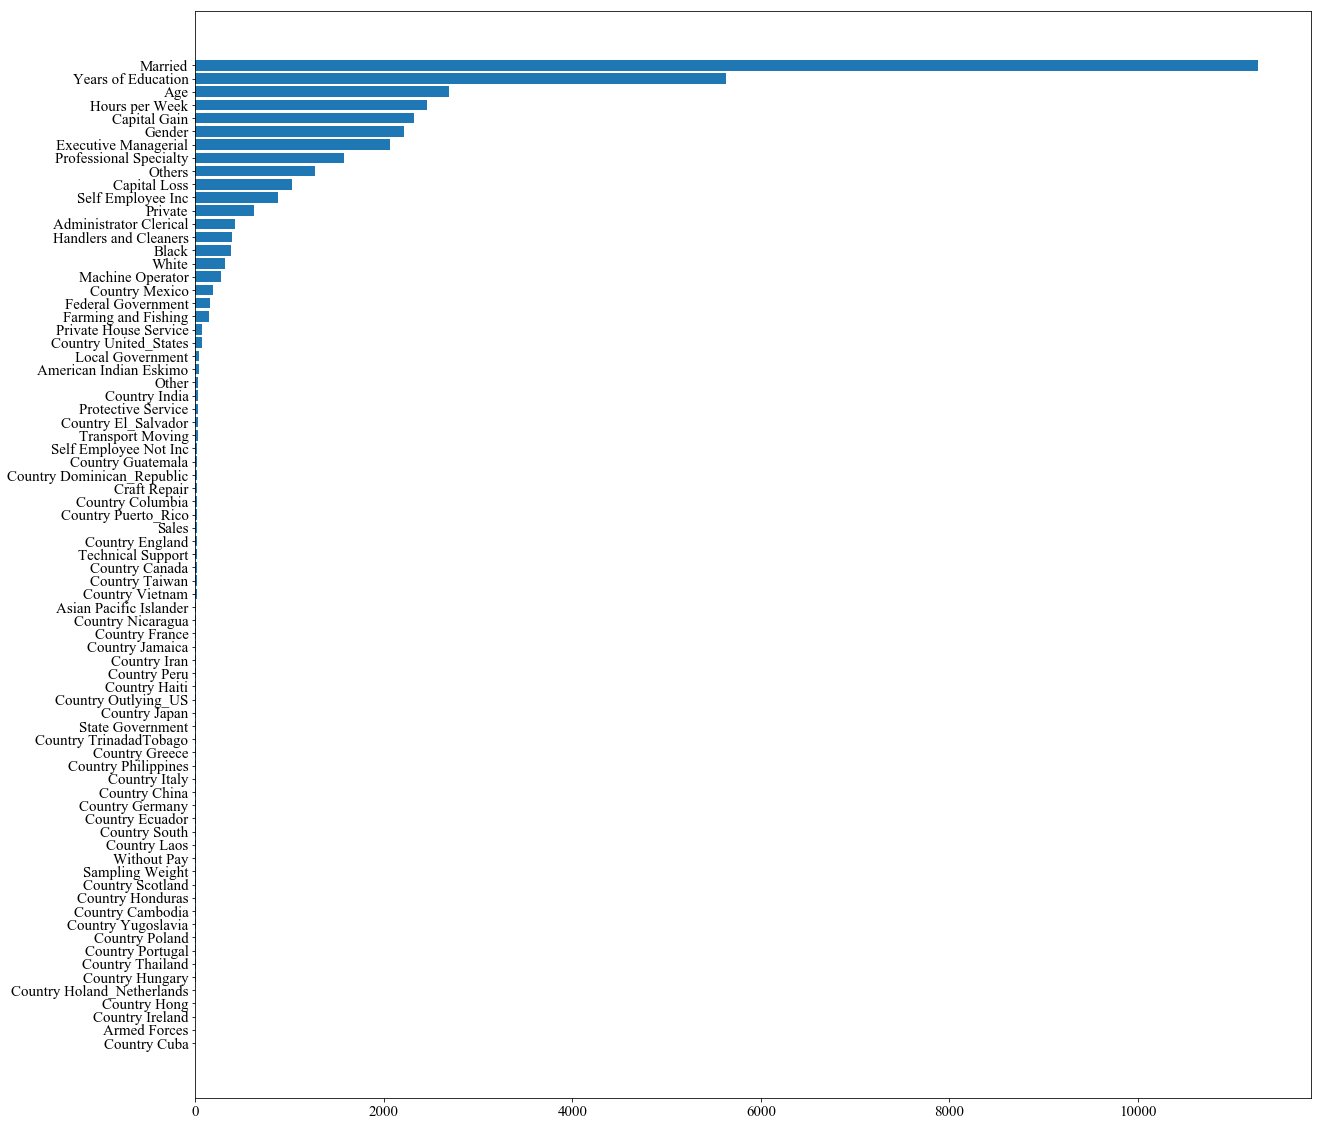

In [149]:
feature_score = {}

for d in range(len(possible_feature)):
    feature_score[possible_feature[d]] = scores[d]

sort_feature = sorted(feature_score, key=feature_score.get)
sort_score = [feature_score[s] for s in sort_feature]

# Plot the feature score
plt.figure(figsize=(20,20))
plt.barh(range(len(sort_feature)), sort_score)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.yticks(range(len(sort_feature)), sort_feature, rotation='horizontal')
plt.savefig('bargraph.png',bbox_inches='tight')
plt.show()

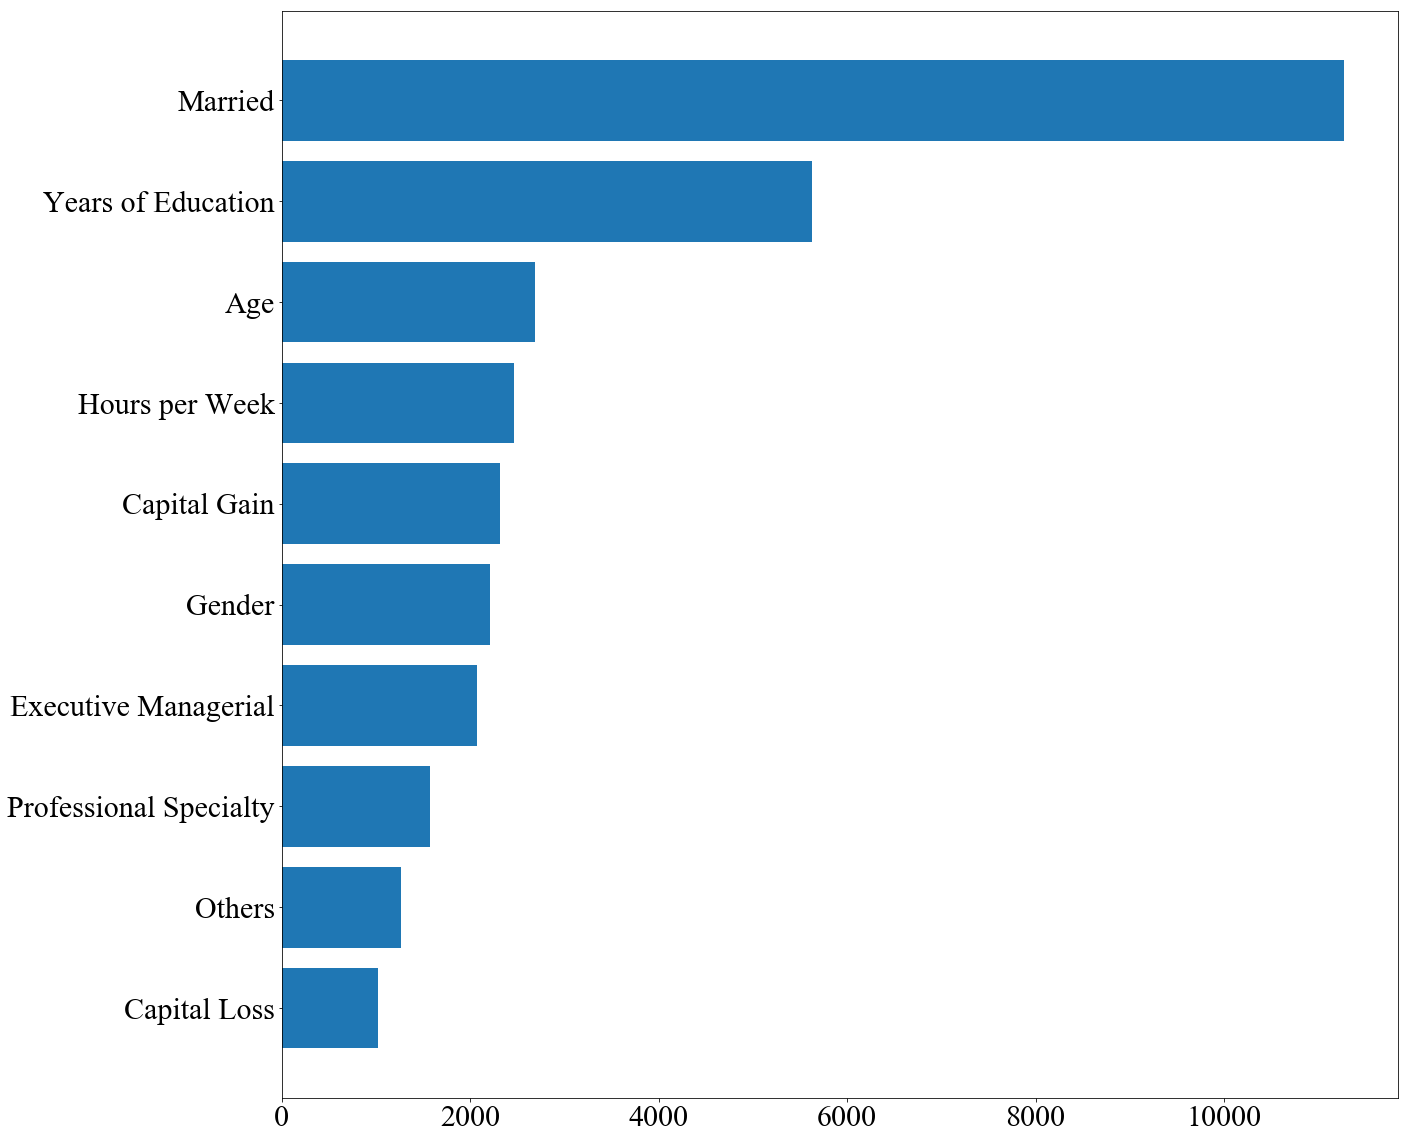

In [151]:
feature_score = {}

for d in range(len(possible_feature)):
    feature_score[possible_feature[d]] = scores[d]

sort_feature = sorted(feature_score, key=feature_score.get)
sort_score = [feature_score[s] for s in sort_feature]

# Plot the feature score
plt.figure(figsize=(20,20))
plt.barh(range(10), sort_score[-10:])
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.yticks(range(10), sort_feature[-10:], rotation='horizontal')
plt.savefig('Top10Features.png',bbox_inches='tight')
plt.show()

## Step 12: Handling Imbalanced Data
## Classifier Baseline with Random Oversampling

In [19]:
ros = RandomOverSampler(ratio = 0.5)

Xros_train, Yros_train = ros.fit_sample(X_train, Y_train)

# AdaBoost
print('AdaBoost Classifier:')
ada_ros = AdaBoostClassifier()
ada_ros.fit(Xros_train, Yros_train)
Y_predict = ada_ros.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Bagging Classifier
print('\nBagging Classifier:')
bg = BaggingClassifier()
bg.fit(Xros_train, Yros_train)
Y_predict = bg.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Gradient Boost
print('\nGradient Boost Classifier:')
gb_ros = GradientBoostingClassifier()
gb_ros.fit(Xros_train, Yros_train)
Y_predict = gb_ros.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Logistic Regression
print('\nLogistic Regression Classifier:')
lr_ros = LogisticRegression()
lr_ros.fit(Xros_train, Yros_train)
Y_predict = lr_ros.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

#Linear SVC
print('\nLinear SVC:')
svc = LinearSVC()
svc.fit(Xros_train, Yros_train)
Y_predict = svc.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# XGBoost
print('\nXGBoost Classifier:')
xg_ros = xgb.XGBClassifier()
xg_ros.fit(Xros_train, Yros_train)
Y_predict = xg_ros.predict(np.array(X_test))

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

AdaBoost Classifier:
0.848671978752
[[10182  1178]
 [ 1101  2599]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.90      0.70      0.90      0.79      0.63     11360
          1       0.69      0.70      0.90      0.70      0.79      0.61      3700

avg / total       0.85      0.85      0.75      0.85      0.79      0.63     15060

0.594619391779
[ 0.89935079  0.69519861]

Bagging Classifier:
0.837250996016
[[10375   985]
 [ 1466  2234]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.91      0.60      0.89      0.78      0.62     11360
          1       0.69      0.60      0.91      0.65      0.78      0.60      3700

avg / total       0.83      0.84      0.68      0.83      0.78      0.61     15060

0.542987410957
[ 0.894358    0.64575806]

Gradient Boost Classifier:
0.856507304117
[[10276  1084]
 [ 1077  2623]]
                   pre       rec       s

## Classifier Baseline with Random Undersampling

In [20]:
rus = RandomUnderSampler(ratio = 0.5)
Xrus_train, Yrus_train = rus.fit_sample(X_train, Y_train)

# AdaBoost
print('AdaBoost Classifier:')
ada_rus = AdaBoostClassifier()
ada_rus.fit(Xrus_train, Yrus_train)
Y_predict = ada_rus.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Bagging Classifier
print('\nBagging Classifier:')
bg = BaggingClassifier()
bg.fit(Xrus_train, Yrus_train)
Y_predict = bg.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Gradient Boost
print('\nGradient Boost Classifier:')
gb_rus = GradientBoostingClassifier()
gb_rus.fit(Xrus_train, Yrus_train)
Y_predict = gb_rus.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Logistic Regression
print('\nLogistic Regression Classifier:')
lr_rus = LogisticRegression()
lr_rus.fit(Xrus_train, Yrus_train)
Y_predict = lr_rus.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

#Linear SVC
print('\nLinear SVC:')
svc = LinearSVC()
svc.fit(Xrus_train, Yrus_train)
Y_predict = svc.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# XGBoost
print('\nXGBoost Classifier:')
xg_rus = xgb.XGBClassifier()
xg_rus.fit(Xrus_train, Yrus_train)
Y_predict = xg_rus.predict(np.array(X_test))

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

AdaBoost Classifier:
0.850531208499
[[10179  1181]
 [ 1070  2630]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.90      0.71      0.90      0.79      0.64     11360
          1       0.69      0.71      0.90      0.70      0.79      0.61      3700

avg / total       0.85      0.85      0.76      0.85      0.79      0.63     15060

0.600889512645
[ 0.90043788  0.70030622]

Bagging Classifier:
0.825298804781
[[9886 1474]
 [1157 2543]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.87      0.69      0.88      0.75      0.58     11360
          1       0.63      0.69      0.87      0.66      0.75      0.55      3700

avg / total       0.83      0.83      0.73      0.83      0.75      0.57     15060

0.54271840257
[ 0.88256037  0.6590644 ]

Gradient Boost Classifier:
0.856839309429
[[10284  1076]
 [ 1080  2620]]
                   pre       rec       spe   

## Classifier Baseline with SMOTE

In [21]:
smt = SMOTE(ratio=0.5)
Xsmt_train, Ysmt_train = smt.fit_sample(X_train, Y_train)

# AdaBoost
print('AdaBoost Classifier:')
ada_smt = AdaBoostClassifier()
ada_smt.fit(Xsmt_train, Ysmt_train)
Y_predict = ada_smt.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Bagging Classifier
print('\nBagging Classifier:')
bg = BaggingClassifier()
bg.fit(Xsmt_train, Ysmt_train)
Y_predict = bg.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Gradient Boost
print('\nGradient Boost Classifier:')
gb_smt = GradientBoostingClassifier()
gb_smt.fit(Xsmt_train, Ysmt_train)
Y_predict = gb_smt.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# Logistic Regression
print('\nLogistic Regression Classifier:')
lr_smt = LogisticRegression()
lr_smt.fit(Xsmt_train, Ysmt_train)
Y_predict = lr_smt.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

#Linear SVC
print('\nLinear SVC:')
svc = LinearSVC()
svc.fit(Xsmt_train, Ysmt_train)
Y_predict = svc.predict(X_test)

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

# XGBoost
print('\nXGBoost Classifier:')
xg_smt = xgb.XGBClassifier()
xg_smt.fit(Xsmt_train, Ysmt_train)
Y_predict = xg_smt.predict(np.array(X_test))

print(accuracy_score(Y_test, Y_predict))
print(confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print(matthews_corrcoef(Y_test, Y_predict))
print(f1_score(Y_test, Y_predict,average=None))

AdaBoost Classifier:
0.850863213811
[[10344  1016]
 [ 1230  2470]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.91      0.67      0.90      0.80      0.64     11360
          1       0.71      0.67      0.91      0.69      0.80      0.62      3700

avg / total       0.85      0.85      0.73      0.85      0.80      0.64     15060

0.5900798919
[ 0.9020668   0.68744782]

Bagging Classifier:
0.838313413015
[[10474   886]
 [ 1549  2151]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.92      0.58      0.90      0.79      0.63     11360
          1       0.71      0.58      0.92      0.64      0.79      0.61      3700

avg / total       0.83      0.84      0.67      0.83      0.79      0.62     15060

0.540055661427
[ 0.89586452  0.63856316]

Gradient Boost Classifier:
0.86374501992
[[10582   778]
 [ 1274  2426]]
                   pre       rec       spe 

## Step 13: Model Tuning and Optimisation
## Fine Tuning Classifier Parameters

In [24]:
def tuneClassifiers(selected_clf, classifiers, params, x, y, x_test, y_test, cv):
    prev_score = 0
    best_clf = None
    clf_list = dict()
    
    for clf_name in selected_clf:
        print ("\n********** TESTING ", clf_name, " *********************")
        myclf = classifiers[clf_name]
        param_grid = params[clf_name]
        clf = GridSearchCV(myclf, param_grid, cv = cv, n_jobs = 3)
        clf.fit(x, y)
        Y_predict = clf.predict(x_test)
        print("accuracy_score:", accuracy_score(y_test, Y_predict))
        print("matthews correlation:", matthews_corrcoef(y_test, Y_predict))
        
        
        print ("\n********** BEST PARAMS for ", clf_name, " *********************")
        print("best estimator:", clf.best_estimator_)
        print("best params:", clf.best_params_)
        print("best score:", clf.best_score_)
        
        clf_list[clf_name] = clf.best_params_
        if prev_score < clf.best_score_: 
            best_clf = clf_name
            prev_score = clf.best_score_
    
    print ("************* BEST CLASSIFIER*************************")
    print ("Best Classifier with highest score ", best_clf)
    
    return clf_list, best_clf

## Tuning max_depth, penalty and dual

In [26]:
classifiers = dict()
classifiers["AdaBoost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
classifiers["GradientBoost"] = GradientBoostingClassifier()
classifiers["LogisticRegression"] = LogisticRegression()
classifiers["XGBClassifier"] = xgb.XGBClassifier()
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier())
classifiers["LinearSVM"] = LinearSVC()

params = dict()
params["AdaBoost"] = dict(
      base_estimator__max_depth = [2, 4, 6, 8, 10]
    )
params["GradientBoost"] = dict(
      max_depth = [2, 4, 6, 8, 10]
    )
params["LogisticRegression"] = dict(
      penalty = ['l1', 'l2']
    )
params["XGBClassifier"] = dict(
      max_depth = [2, 4, 6, 8, 10]
    )
params["BaggingClassifier"] = dict(
      base_estimator__max_depth = [8,10,12,14]
    )
params["LinearSVM"] = dict(
      dual  = [True, False]
    )

clf_list, best_clf = tuneClassifiers(classifiers.keys(), classifiers, params, X_train, np.array(Y_train).ravel(), X_test, Y_test, 3)


********** TESTING  AdaBoost  *********************
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341

********** BEST PARAMS for  AdaBoost  *********************
best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
best params: {'base_estimator__max_depth': 2}
best score: 0.864398912539

********** TESTING  GradientBoost  *********************
accuracy_score: 0.870584329349
matthews correlation: 0.635471559755

********** BEST PARAMS for  GradientBoost  *********************
best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              lea

## Tuning n_estimators and max_iter

In [27]:
classifiers = dict()
classifiers["AdaBoost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))
classifiers["GradientBoost"] = GradientBoostingClassifier(max_depth=6)
classifiers["LogisticRegression"] = LogisticRegression(penalty='l1')
classifiers["XGBClassifier"] = xgb.XGBClassifier(max_depth=6)
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14))
classifiers["LinearSVM"] = LinearSVC(dual=False)

params = dict()
params["AdaBoost"] = dict(
      n_estimators = [50, 100, 250, 500, 700]
    )
params["GradientBoost"] = dict(
      n_estimators = [50, 100, 250, 500, 700]
    )
params["LogisticRegression"] = dict(
      max_iter = [100, 250, 500, 700, 1000]
    )
params["XGBClassifier"] = dict(
      n_estimators = [50, 100, 250, 500, 700]
    )
params["BaggingClassifier"] = dict(
      n_estimators = [50, 100, 250, 500, 700]
    )
params["LinearSVM"] = dict(
      fit_intercept   = [True, False]
    )


clf_list, best_clf = tuneClassifiers(classifiers.keys(), classifiers, params, X_train, np.array(Y_train).ravel(), X_test, Y_test, 3)


********** TESTING  AdaBoost  *********************
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341

********** BEST PARAMS for  AdaBoost  *********************
best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
best params: {'n_estimators': 50}
best score: 0.864398912539

********** TESTING  GradientBoost  *********************
accuracy_score: 0.870451527224
matthews correlation: 0.635091554907

********** BEST PARAMS for  GradientBoost  *********************
best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0

## Tuning learning_rate

In [29]:
classifiers = dict()
classifiers["AdaBoost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50)
classifiers["GradientBoost"] = GradientBoostingClassifier(max_depth=6, n_estimators=100)
classifiers["LogisticRegression"] = LogisticRegression(penalty='l1', max_iter=100)
classifiers["XGBClassifier"] = xgb.XGBClassifier(max_depth=6, n_estimators=100)
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=700)
classifiers["LinearSVM"] = LinearSVC(dual=False, fit_intercept=False)

params = dict()
params["AdaBoost"] = dict(
      learning_rate = [0.1, 0.25, 1, 10]
    )
params["GradientBoost"] = dict(
      learning_rate = [0.1, 0.25, 1, 10]
    )
params["LogisticRegression"] = dict(
      C = [0.1, 0.25, 1, 10]
    )
params["XGBClassifier"] = dict(
      learning_rate = [0.1, 0.25, 1, 10]
    )
params["BaggingClassifier"] = dict(
      max_features = [60, 65, 70, 75]
    )
params["LinearSVM"] = dict(
      C = [0.1, 0.25, 1, 10]
    )

clf_list, best_clf = tuneClassifiers(classifiers.keys(), classifiers, params, X_train, np.array(Y_train).ravel(), X_test, Y_test, 3)


********** TESTING  AdaBoost  *********************
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341

********** BEST PARAMS for  AdaBoost  *********************
best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1, n_estimators=50, random_state=None)
best params: {'learning_rate': 1}
best score: 0.864398912539

********** TESTING  GradientBoost  *********************
accuracy_score: 0.870849933599
matthews correlation: 0.63623156945

********** BEST PARAMS for  GradientBoost  *********************
best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1,

## Tuning algorithm, loss, class_weight, and objective

In [30]:
classifiers = dict()
classifiers["AdaBoost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, learning_rate=1)
classifiers["GradientBoost"] = GradientBoostingClassifier(max_depth=6, n_estimators=100, learning_rate=0.1)
classifiers["LogisticRegression"] = LogisticRegression(penalty='l1', max_iter=100, C=1)
classifiers["XGBClassifier"] = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1)
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=700, max_features=60)
classifiers["LinearSVM"] = LinearSVC(dual=False, fit_intercept=False, C=10)

params = dict()
params["AdaBoost"] = dict(
    algorithm = ['SAMME', 'SAMME.R']
    )
params["GradientBoost"] = dict(
    loss = ['deviance', 'exponential']
    )
params["LogisticRegression"] = dict(
      class_weight = [None, 'balanced']
    )
params["XGBClassifier"] = dict(
      objective = ['reg:linear', 'reg:logistic', 'reg:gamma', 'count:poisson']
    )
params["BaggingClassifier"] = dict(
      max_samples = [0.4, 0.5, 0.6, 0.7, 1.0]
    )
params["LinearSVM"] = dict(
      class_weight = [None, 'balanced']
    )

clf_list, best_clf = tuneClassifiers(classifiers.keys(), classifiers, params, X_train, np.array(Y_train).ravel(), X_test, Y_test, 3)


********** TESTING  AdaBoost  *********************
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341

********** BEST PARAMS for  AdaBoost  *********************
best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1, n_estimators=50, random_state=None)
best params: {'algorithm': 'SAMME.R'}
best score: 0.864398912539

********** TESTING  GradientBoost  *********************
accuracy_score: 0.870517928287
matthews correlation: 0.635347313917

********** BEST PARAMS for  GradientBoost  *********************
best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate

## Tuned Parameters with Original Data and Sampled Data

In [15]:
classifiers = dict()
classifiers["AdaBoost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, learning_rate=1, algorithm='SAMME.R')
classifiers["GradientBoost"] = GradientBoostingClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, loss='exponential')
classifiers["LogisticRegression"] = LogisticRegression(penalty='l1', max_iter=100, C=1, class_weight=None)
classifiers["XGBClassifier"] = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, objective='reg:logistic')
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=700, max_features=60, max_samples=1.0)
classifiers["LinearSVM"] = LinearSVC(dual=False, fit_intercept=False, C=10, class_weight=None)

In [16]:
def evaluateClassifiers(selected_clf, classifiers, x, y, x_test, y_test, cv):
    prev_score = 0
    best_clf = None

    for clf_name in selected_clf:
        print ("\n********** TESTING ", clf_name, " *********************")
        myclf = classifiers[clf_name]
        scores = cross_val_score(myclf, x, y, cv=cv, n_jobs = 3)
        myclf.fit(x, y)
        Y_predict = myclf.predict(x_test)
        print("accuracy_score:", accuracy_score(y_test, Y_predict))
        print("matthews correlation:", matthews_corrcoef(y_test, Y_predict))
        print("f1-score:",f1_score(y_test, Y_predict,average=None))   
        print("Mean Cross-Validation Score:", np.mean(scores)) 
        print("CV Score:", scores)
        print(confusion_matrix(y_test, Y_predict))
        print(classification_report_imbalanced(y_test, Y_predict))
               
        if prev_score < np.mean(scores): 
            best_clf = clf_name
            prev_score = np.mean(scores)
    
    print ("************* BEST CLASSIFIER*************************")
    print ("Best Classifier with highest score ", best_clf)
    
    return best_clf

In [17]:
print('********** Cross Validation with No Sampling **********')
best_clf = evaluateClassifiers(classifiers.keys(), classifiers, X_train, np.array(Y_train).ravel(), X_test, Y_test, 10)

********** Cross Validation with No Sampling **********

********** TESTING  AdaBoost  *********************
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341
f1-score: [ 0.91247528  0.70312044]
Mean Cross-Validation Score: 0.864432808199
CV Score: [ 0.8597945   0.86244614  0.86708651  0.85482267  0.86803714  0.85974801
  0.86405836  0.87068966  0.87031509  0.86733002]
[[10613   747]
 [ 1289  2411]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.93      0.65      0.91      0.83      0.69     11360
          1       0.76      0.65      0.93      0.70      0.83      0.67      3700

avg / total       0.86      0.86      0.72      0.86      0.83      0.69     15060


********** TESTING  GradientBoost  *********************
accuracy_score: 0.870385126162
matthews correlation: 0.634923495419
f1-score: [ 0.91617281  0.71436933]
Mean Cross-Validation Score: 0.869041155064
CV Score: [ 0.86576069  0.86675505  0.

In [22]:
print('********** Cross Validation with Random Oversampling **********')
best_clf = evaluateClassifiers(classifiers.keys(), classifiers, Xros_train, np.array(Yros_train).ravel(), np.array(X_test), Y_test, 10)

********** Cross Validation with Random Oversampling **********

********** TESTING  AdaBoost  *********************
accuracy_score: 0.854980079681
matthews correlation: 0.620234450301
f1-score: [ 0.9025609   0.71658448]
Mean Cross-Validation Score: 0.84603232234
CV Score: [ 0.8381877   0.84671962  0.84201236  0.8378935   0.84432019  0.85432607
  0.85373749  0.84574625  0.85222255  0.84515749]
[[10115  1245]
 [  939  2761]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.89      0.75      0.90      0.79      0.64     11360
          1       0.69      0.75      0.89      0.72      0.79      0.62      3700

avg / total       0.86      0.85      0.78      0.86      0.79      0.64     15060


********** TESTING  GradientBoost  *********************
accuracy_score: 0.862616201859
matthews correlation: 0.6343822874
f1-score: [ 0.90834994  0.72577866]
Mean Cross-Validation Score: 0.855272888334
CV Score: [ 0.84554281  0.8543689

In [23]:
print('********** Cross Validation with Random Undersampling **********')
best_clf = evaluateClassifiers(classifiers.keys(), classifiers, Xrus_train, np.array(Yrus_train).ravel(), np.array(X_test), Y_test, 10)

********** Cross Validation with Random Undersampling **********

********** TESTING  AdaBoost  *********************
accuracy_score: 0.856175298805
matthews correlation: 0.618686667224
f1-score: [ 0.90388711  0.71439873]
Mean Cross-Validation Score: 0.842079168881
CV Score: [ 0.85707945  0.83710608  0.83710608  0.83710608  0.83888149  0.84775854
  0.83969805  0.84813499  0.83696135  0.84095957]
[[10185  1175]
 [  991  2709]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.90      0.73      0.90      0.80      0.65     11360
          1       0.70      0.73      0.90      0.71      0.80      0.62      3700

avg / total       0.86      0.86      0.77      0.86      0.80      0.64     15060


********** TESTING  GradientBoost  *********************
accuracy_score: 0.860491367862
matthews correlation: 0.631364624177
f1-score: [ 0.90663467  0.72416962]
Mean Cross-Validation Score: 0.853888291029
CV Score: [ 0.87039503  0.848

In [24]:
print('********** Cross Validation with SMOTE **********')
best_clf = evaluateClassifiers(classifiers.keys(), classifiers, Xsmt_train, np.array(Ysmt_train).ravel(), np.array(X_test), Y_test, 10)

********** Cross Validation with SMOTE **********

********** TESTING  AdaBoost  *********************
accuracy_score: 0.864409030544
matthews correlation: 0.620316846987
f1-score: [ 0.91192961  0.70550909]
Mean Cross-Validation Score: 0.877294733504
CV Score: [ 0.83436305  0.84171815  0.8452486   0.84171815  0.84284873  0.84167157
  0.88728664  0.9478952   0.95025022  0.93994701]
[[10572   788]
 [ 1254  2446]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.93      0.66      0.91      0.82      0.69     11360
          1       0.76      0.66      0.93      0.71      0.82      0.67      3700

avg / total       0.86      0.86      0.73      0.86      0.82      0.68     15060


********** TESTING  GradientBoost  *********************
accuracy_score: 0.867463479416
matthews correlation: 0.630274769786
f1-score: [ 0.91372007  0.71428571]
Mean Cross-Validation Score: 0.879648773926
CV Score: [ 0.83759929  0.84260076  0.847308

## Step 14: Plot Receiver Operating Characteristic (ROC) Curve

In [51]:
Y_binarize_train = label_binarize(Y_train, classes=[0, 1, 2])
Y_binarize_train = Y_binarize_train[:,:-1]

Y_binarize_test = label_binarize(Y_test, classes=[0, 1, 2])
Y_binarize_test = Y_binarize_test[:,:-1]

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, learning_rate=1, algorithm='SAMME.R')

gb = GradientBoostingClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, loss='exponential')

lr = LogisticRegression(penalty='l1', max_iter=100, C=1, class_weight=None)

xg = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, objective='reg:logistic')

bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=700, max_features=60, max_samples=1.0)

svm = OneVsRestClassifier(LinearSVC(dual=False, fit_intercept=False, C=10, class_weight=None))

Y_ada_score = ada.fit(X_train, Y_train).predict_proba(X_test)

Y_gb_score = gb.fit(X_train, Y_train).predict_proba(X_test)

Y_lr_score = lr.fit(X_train, Y_train).predict_proba(X_test)

Y_xgb_score = xg.fit(X_train, Y_train).predict_proba(X_test)

Y_bg_score = bg.fit(X_train, Y_train).predict_proba(X_test)

Y_svm_score = svm.fit(X_train, Y_binarize_train).decision_function(X_test)

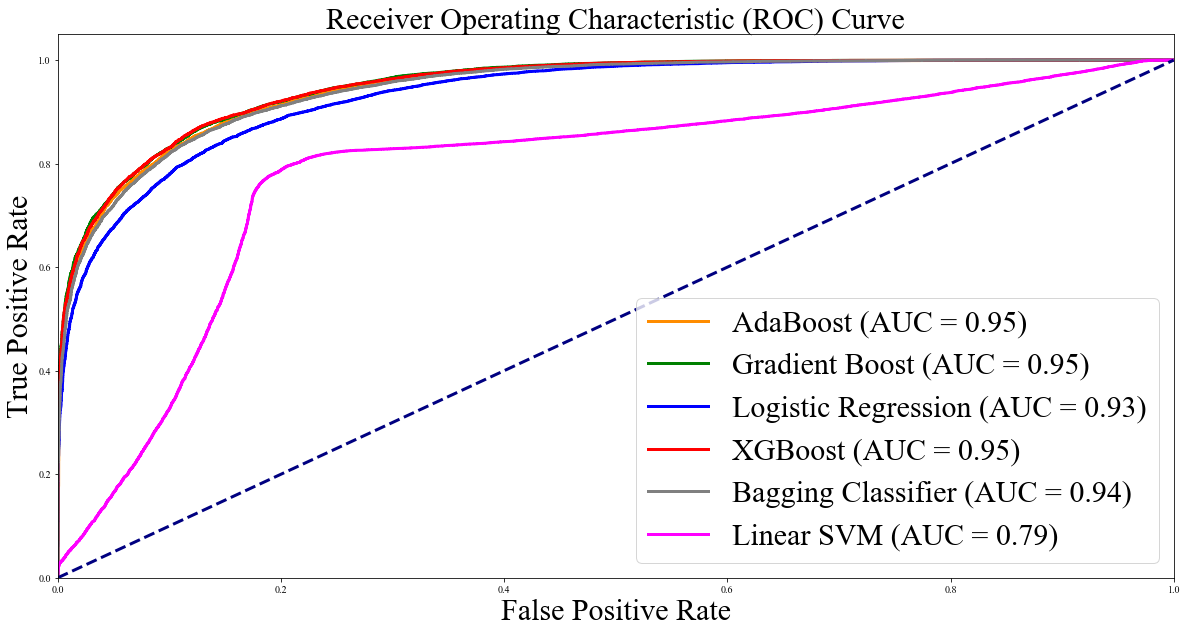

In [54]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# AdaBoost
fpr["AdaBoost"], tpr["AdaBoost"], _ = roc_curve(Y_binarize_test.ravel(), Y_ada_score.ravel())
roc_auc["AdaBoost"] = auc(fpr["AdaBoost"], tpr["AdaBoost"])

# GradientBoost
fpr["GradientBoost"], tpr["GradientBoost"], _ = roc_curve(Y_binarize_test.ravel(), Y_gb_score.ravel())
roc_auc["GradientBoost"] = auc(fpr["GradientBoost"], tpr["GradientBoost"])

# LogisticRegression
fpr["LogisticRegression"], tpr["LogisticRegression"], _ = roc_curve(Y_binarize_test.ravel(), Y_lr_score.ravel())
roc_auc["LogisticRegression"] = auc(fpr["LogisticRegression"], tpr["LogisticRegression"])

# XGBClassifier
fpr["XGBClassifier"], tpr["XGBClassifier"], _ = roc_curve(Y_binarize_test.ravel(), Y_xgb_score.ravel())
roc_auc["XGBClassifier"] = auc(fpr["XGBClassifier"], tpr["XGBClassifier"])

# BaggingClassifier
fpr["BaggingClassifier"], tpr["BaggingClassifier"], _ = roc_curve(Y_binarize_test.ravel(), Y_bg_score.ravel())
roc_auc["BaggingClassifier"] = auc(fpr["BaggingClassifier"], tpr["BaggingClassifier"])

# LinearSVM
fpr["LinearSVM"], tpr["LinearSVM"], _ = roc_curve(Y_binarize_test.ravel(), Y_svm_score.ravel())
roc_auc["LinearSVM"] = auc(fpr["LinearSVM"], tpr["LinearSVM"])

lw = 3

plt.figure(figsize=(20,10))

plt.plot(fpr["AdaBoost"], tpr["AdaBoost"], color='darkorange', lw=lw, label='AdaBoost (AUC = %0.2f)' % roc_auc["AdaBoost"])
plt.plot(fpr["GradientBoost"], tpr["GradientBoost"], color='green', lw=lw, label='Gradient Boost (AUC = %0.2f)' % roc_auc["GradientBoost"])
plt.plot(fpr["LogisticRegression"], tpr["LogisticRegression"], color='blue', lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc["LogisticRegression"])
plt.plot(fpr["XGBClassifier"], tpr["XGBClassifier"], color='red', lw=lw, label='XGBoost (AUC = %0.2f)' % roc_auc["XGBClassifier"])
plt.plot(fpr["BaggingClassifier"], tpr["BaggingClassifier"], color='gray', lw=lw, label='Bagging Classifier (AUC = %0.2f)' % roc_auc["BaggingClassifier"])
plt.plot(fpr["LinearSVM"], tpr["LinearSVM"], color='magenta', lw=lw, label='Linear SVM (AUC = %0.2f)' % roc_auc["LinearSVM"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.savefig('ROC.png',bbox_inches='tight')
plt.show()

## Step 15: Plot Overall Precision Recall Curve

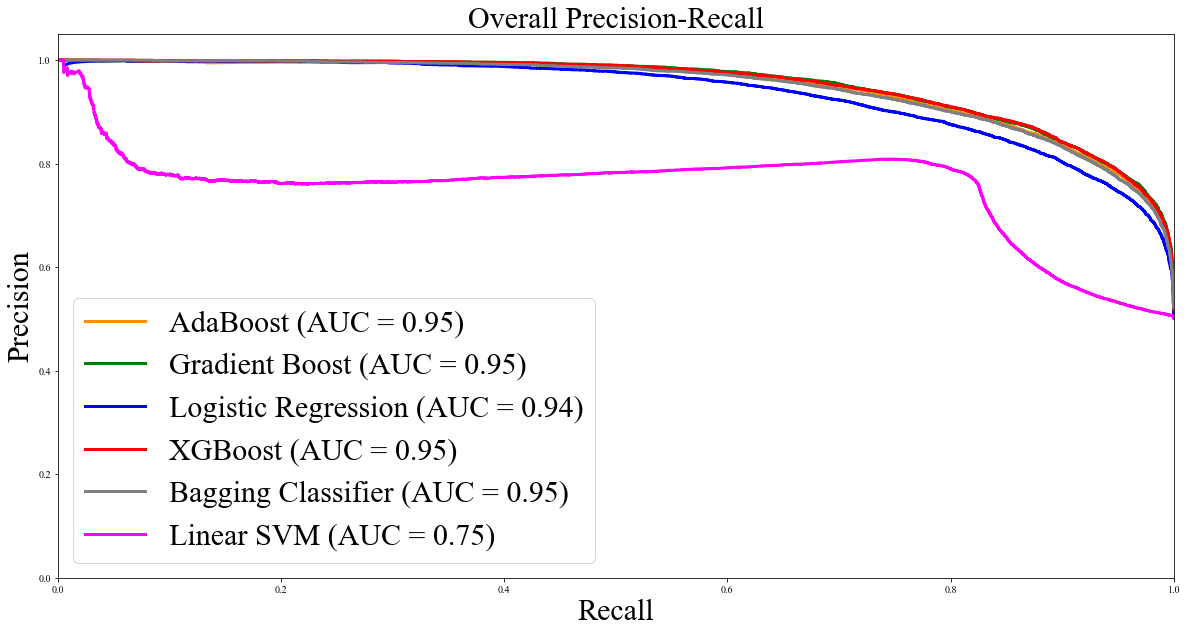

In [56]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

# AdaBoost
precision["AdaBoost"], recall["AdaBoost"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_ada_score.ravel())
average_precision["AdaBoost"] = average_precision_score(Y_binarize_test.ravel(), Y_ada_score.ravel())

# GradientBoost
precision["GradientBoost"], recall["GradientBoost"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_gb_score.ravel())
average_precision["GradientBoost"] = average_precision_score(Y_binarize_test.ravel(), Y_gb_score.ravel())

# LogisticRegression
precision["LogisticRegression"], recall["LogisticRegression"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_lr_score.ravel())
average_precision["LogisticRegression"] = average_precision_score(Y_binarize_test.ravel(), Y_lr_score.ravel())

# XGBClassifier
precision["XGBClassifier"], recall["XGBClassifier"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_xgb_score.ravel())
average_precision["XGBClassifier"] = average_precision_score(Y_binarize_test.ravel(), Y_xgb_score.ravel())

# BaggingClassifier
precision["BaggingClassifier"], recall["BaggingClassifier"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_bg_score.ravel())
average_precision["BaggingClassifier"] = average_precision_score(Y_binarize_test.ravel(), Y_bg_score.ravel())

# LinearSVM
precision["LinearSVM"], recall["LinearSVM"], _ = precision_recall_curve(Y_binarize_test.ravel(), Y_svm_score.ravel())
average_precision["LinearSVM"] = average_precision_score(Y_binarize_test.ravel(), Y_svm_score.ravel())

plt.figure(figsize=(20,10))
plt.plot(recall["AdaBoost"], precision["AdaBoost"], color='darkorange', lw=lw, label='AdaBoost (AUC = {0:0.2f})'
               ''.format(average_precision["AdaBoost"]))
plt.plot(recall["GradientBoost"], precision["GradientBoost"], color='green', lw=lw, label='Gradient Boost (AUC = {0:0.2f})'
               ''.format(average_precision["GradientBoost"]))
plt.plot(recall["LogisticRegression"], precision["LogisticRegression"], color='blue', lw=lw, label='Logistic Regression (AUC = {0:0.2f})'
               ''.format(average_precision["LogisticRegression"]))
plt.plot(recall["XGBClassifier"], precision["XGBClassifier"], color='red', lw=lw, label='XGBoost (AUC = {0:0.2f})'
               ''.format(average_precision["XGBClassifier"]))
plt.plot(recall["BaggingClassifier"], precision["BaggingClassifier"], color='gray', lw=lw, label='Bagging Classifier (AUC = {0:0.2f})'
               ''.format(average_precision["BaggingClassifier"]))
plt.plot(recall["LinearSVM"], precision["LinearSVM"], color='magenta', lw=lw, label='Linear SVM (AUC = {0:0.2f})'
               ''.format(average_precision["LinearSVM"]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.title('Overall Precision-Recall',fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.savefig('OverallPRC.png',bbox_inches='tight')
plt.show()

## Plot Class <=50k Precision Recall Curve

In [50]:
print(Y_binarize_test.shape,Y_ada_score.shape)

(15060, 2) (30120,)


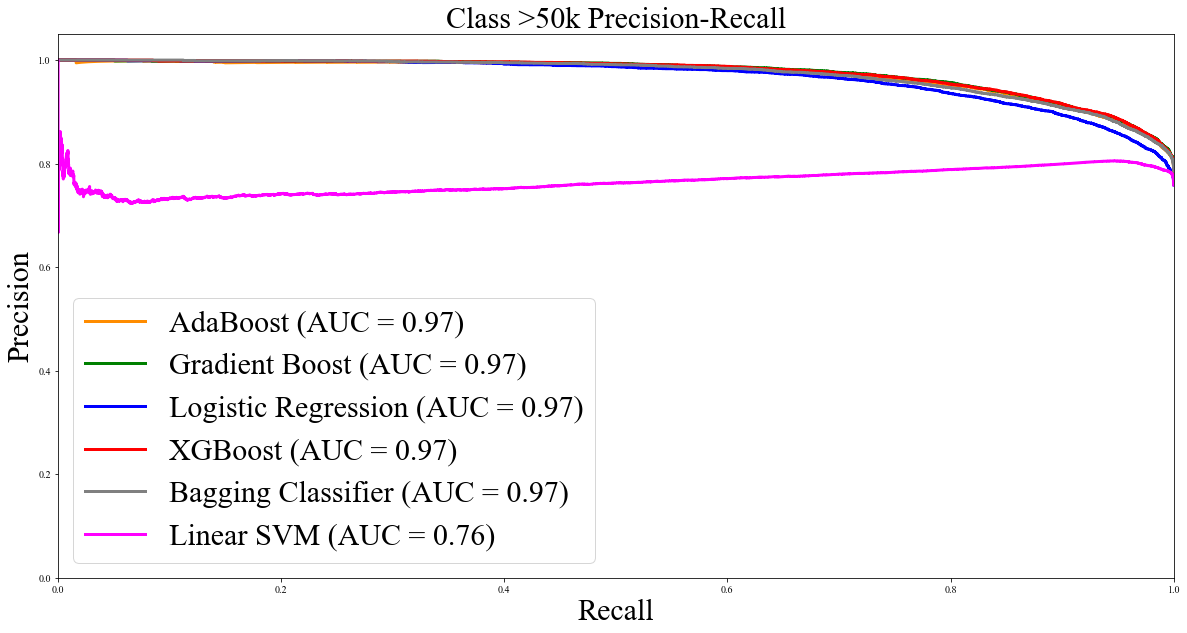

In [57]:
# Compute Precision-Recall and plot curve
i = 0
precision = dict()
recall = dict()
average_precision = dict()

# AdaBoost
precision["AdaBoost"], recall["AdaBoost"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_ada_score[:, i])
average_precision["AdaBoost"] = average_precision_score(Y_binarize_test[:, i], Y_ada_score[:, i])

# GradientBoost
precision["GradientBoost"], recall["GradientBoost"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_gb_score[:, i])
average_precision["GradientBoost"] = average_precision_score(Y_binarize_test[:, i], Y_gb_score[:, i])

# LogisticRegression
precision["LogisticRegression"], recall["LogisticRegression"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_lr_score[:, i])
average_precision["LogisticRegression"] = average_precision_score(Y_binarize_test[:, i], Y_lr_score[:, i])

# XGBClassifier
precision["XGBClassifier"], recall["XGBClassifier"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_xgb_score[:, i])
average_precision["XGBClassifier"] = average_precision_score(Y_binarize_test[:, i], Y_xgb_score[:, i])

# BaggingClassifier
precision["BaggingClassifier"], recall["BaggingClassifier"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_bg_score[:, i])
average_precision["BaggingClassifier"] = average_precision_score(Y_binarize_test[:, i], Y_bg_score[:, i])

# LinearSVM
precision["LinearSVM"], recall["LinearSVM"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_svm_score[:, i])
average_precision["LinearSVM"] = average_precision_score(Y_binarize_test[:, i], Y_svm_score[:, i])

plt.figure(figsize=(20,10))
plt.plot(recall["AdaBoost"], precision["AdaBoost"], color='darkorange', lw=lw, label='AdaBoost (AUC = {0:0.2f})'
               ''.format(average_precision["AdaBoost"]))
plt.plot(recall["GradientBoost"], precision["GradientBoost"], color='green', lw=lw, label='Gradient Boost (AUC = {0:0.2f})'
               ''.format(average_precision["GradientBoost"]))
plt.plot(recall["LogisticRegression"], precision["LogisticRegression"], color='blue', lw=lw, label='Logistic Regression (AUC = {0:0.2f})'
               ''.format(average_precision["LogisticRegression"]))
plt.plot(recall["XGBClassifier"], precision["XGBClassifier"], color='red', lw=lw, label='XGBoost (AUC = {0:0.2f})'
               ''.format(average_precision["XGBClassifier"]))
plt.plot(recall["BaggingClassifier"], precision["BaggingClassifier"], color='gray', lw=lw, label='Bagging Classifier (AUC = {0:0.2f})'
               ''.format(average_precision["BaggingClassifier"]))
plt.plot(recall["LinearSVM"], precision["LinearSVM"], color='magenta', lw=lw, label='Linear SVM (AUC = {0:0.2f})'
               ''.format(average_precision["LinearSVM"]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.title('Class >50k Precision-Recall',fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.savefig('ClassGT50KPRC.png',bbox_inches='tight')
plt.show()

## Plot Class >50k Precision Recall Curve

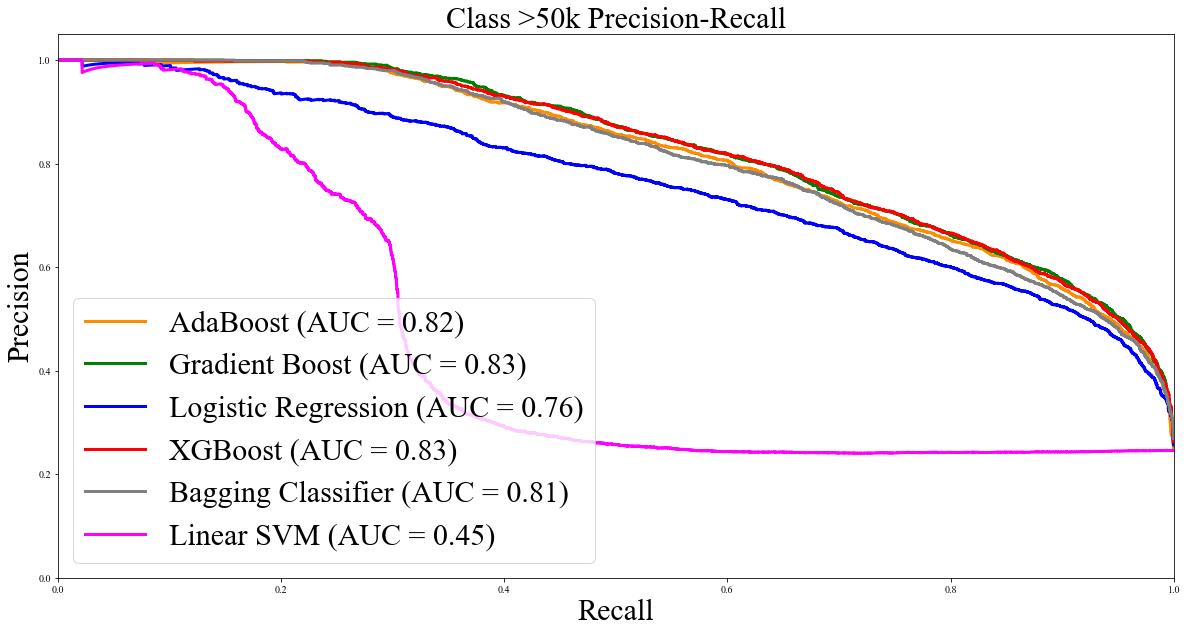

In [58]:
# Compute Precision-Recall and plot curve
i = 1
precision = dict()
recall = dict()
average_precision = dict()

# AdaBoost
precision["AdaBoost"], recall["AdaBoost"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_ada_score[:, i])
average_precision["AdaBoost"] = average_precision_score(Y_binarize_test[:, i], Y_ada_score[:, i])

# GradientBoost
precision["GradientBoost"], recall["GradientBoost"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_gb_score[:, i])
average_precision["GradientBoost"] = average_precision_score(Y_binarize_test[:, i], Y_gb_score[:, i])

# LogisticRegression
precision["LogisticRegression"], recall["LogisticRegression"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_lr_score[:, i])
average_precision["LogisticRegression"] = average_precision_score(Y_binarize_test[:, i], Y_lr_score[:, i])

# XGBClassifier
precision["XGBClassifier"], recall["XGBClassifier"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_xgb_score[:, i])
average_precision["XGBClassifier"] = average_precision_score(Y_binarize_test[:, i], Y_xgb_score[:, i])

# BaggingClassifier
precision["BaggingClassifier"], recall["BaggingClassifier"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_bg_score[:, i])
average_precision["BaggingClassifier"] = average_precision_score(Y_binarize_test[:, i], Y_bg_score[:, i])

# LinearSVM
precision["LinearSVM"], recall["LinearSVM"], _ = precision_recall_curve(Y_binarize_test[:, i], Y_svm_score[:, i])
average_precision["LinearSVM"] = average_precision_score(Y_binarize_test[:, i], Y_svm_score[:, i])

plt.figure(figsize=(20,10))
plt.plot(recall["AdaBoost"], precision["AdaBoost"], color='darkorange', lw=lw, label='AdaBoost (AUC = {0:0.2f})'
               ''.format(average_precision["AdaBoost"]))
plt.plot(recall["GradientBoost"], precision["GradientBoost"], color='green', lw=lw, label='Gradient Boost (AUC = {0:0.2f})'
               ''.format(average_precision["GradientBoost"]))
plt.plot(recall["LogisticRegression"], precision["LogisticRegression"], color='blue', lw=lw, label='Logistic Regression (AUC = {0:0.2f})'
               ''.format(average_precision["LogisticRegression"]))
plt.plot(recall["XGBClassifier"], precision["XGBClassifier"], color='red', lw=lw, label='XGBoost (AUC = {0:0.2f})'
               ''.format(average_precision["XGBClassifier"]))
plt.plot(recall["BaggingClassifier"], precision["BaggingClassifier"], color='gray', lw=lw, label='Bagging Classifier (AUC = {0:0.2f})'
               ''.format(average_precision["BaggingClassifier"]))
plt.plot(recall["LinearSVM"], precision["LinearSVM"], color='magenta', lw=lw, label='Linear SVM (AUC = {0:0.2f})'
               ''.format(average_precision["LinearSVM"]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.title('Class >50k Precision-Recall',fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.savefig('ClassGT50KPRC.png',bbox_inches='tight')
plt.show()

## Step 16: Measure Execution Performance

In [59]:
def executionTimeClassifiers(selected_clf, classifiers, x, y, x_test, y_test):
    prev_score = datetime.timedelta(seconds=180)
    best_clf = None
    result = dict()
    
    for clf_name in selected_clf:
        print("\n********** TESTING ", clf_name, " *********************")
        start = datetime.datetime.now()
        print("Start Time:", start)
        myclf = classifiers[clf_name]
        myclf.fit(x, y)
        Y_predict = myclf.predict(x_test)
        print("accuracy_score:", accuracy_score(y_test, Y_predict))
        print("matthews correlation:", matthews_corrcoef(y_test, Y_predict))
        print("f1-score:",f1_score(y_test, Y_predict,average=None))   
        print(confusion_matrix(y_test, Y_predict))
        print(classification_report_imbalanced(y_test, Y_predict))
        
        end = datetime.datetime.now()
        print("End Time:", end)
        
        elapsed = end - start
        print("Elapsed Time (in seconds):", elapsed.total_seconds())
        
        result[clf_name] = [float(elapsed.total_seconds()), accuracy_score(y_test, Y_predict)*100.0]
        
        if prev_score > elapsed: 
            best_clf = clf_name
            prev_score = elapsed
    
    print ("************* FASTEST CLASSIFIER*************************")
    print ("Fastest with highest score ", best_clf)
    
    return best_clf, result

In [60]:
classifiers = dict()
classifiers["Ada Boost"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, learning_rate=1, algorithm='SAMME.R')
classifiers["Gradient Boost"] = GradientBoostingClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, loss='exponential')
classifiers["Logistic Regression"] = LogisticRegression(penalty='l1', max_iter=100, C=1, class_weight=None)
classifiers["XGBoost"] = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, objective='reg:logistic')
classifiers["BaggingClassifier"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=700, max_features=60, max_samples=1.0)
classifiers["LinearSVM"] = LinearSVC(dual=False, fit_intercept=False, C=10, class_weight=None)

print('********** Classifier Execution Performance **********')
fast_clf, fast_result = executionTimeClassifiers(classifiers.keys(), classifiers, X_train, np.array(Y_train).ravel(), X_test, Y_test)

********** Classifier Execution Performance **********

********** TESTING  Ada Boost  *********************
Start Time: 2017-06-04 10:44:07.119391
accuracy_score: 0.864807436919
matthews correlation: 0.619542685341
f1-score: [ 0.91247528  0.70312044]
[[10613   747]
 [ 1289  2411]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.93      0.65      0.91      0.83      0.69     11360
          1       0.76      0.65      0.93      0.70      0.83      0.67      3700

avg / total       0.86      0.86      0.72      0.86      0.83      0.69     15060

End Time: 2017-06-04 10:44:09.828325
Elapsed Time (in seconds): 2.708934

********** TESTING  Gradient Boost  *********************
Start Time: 2017-06-04 10:44:09.828325
accuracy_score: 0.870385126162
matthews correlation: 0.634923495419
f1-score: [ 0.91617281  0.71436933]
[[10667   693]
 [ 1259  2441]]
                   pre       rec       spe        f1       geo       iba    

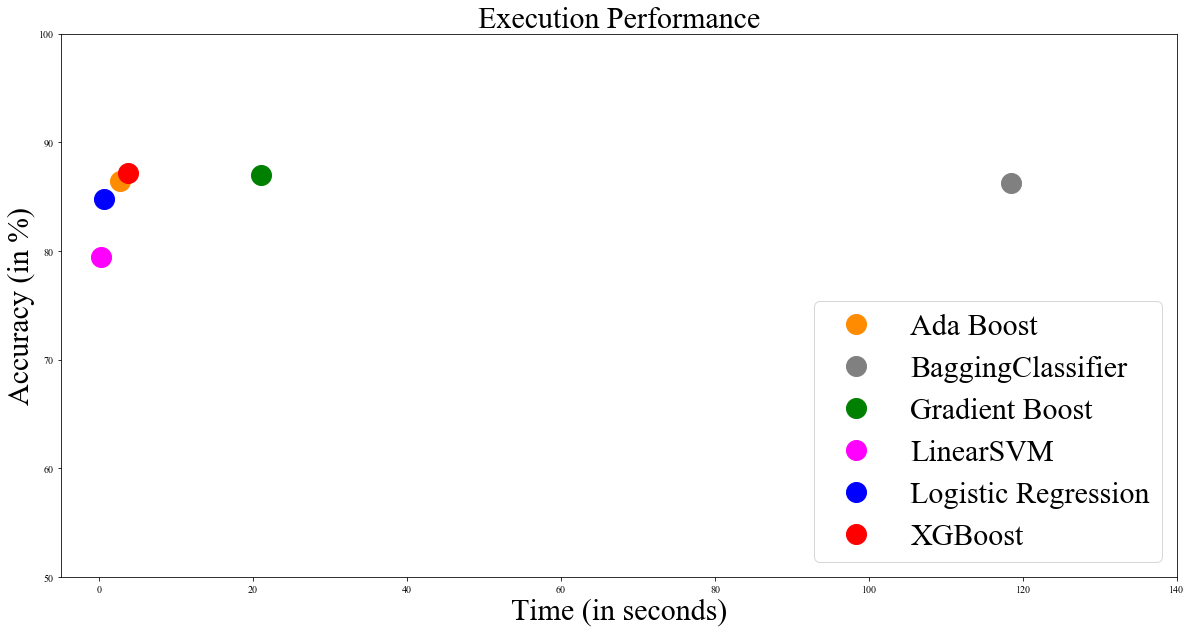

In [62]:
x = [fast_result[key][0] for key in fast_result.keys()]
y = [fast_result[key][1] for key in fast_result.keys()]
labels = [key for key in fast_result.keys()]

df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

colors = ['darkorange', 'gray', 'green',  'magenta', 'blue', 'red']

plt.figure(figsize=(20,10))
i = 0
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=20, color=colors[i], label=name)
    i+=1
plt.xlim([-5.0, 140.0])
plt.ylim([50, 100])
plt.xlabel('Time (in seconds)',fontsize=30)
plt.ylabel('Accuracy (in %)',fontsize=30)
plt.title('Execution Performance',fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.savefig('ExecPerformance.png',bbox_inches='tight')
plt.show()